# Imports

In [1]:
print("hi")

hi


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# stdlib
import os
import shutil
import sqlite3

# 3rd party
from IPython.display import display
import ipyparallel as ipp
import ipyvolume as ipv
import ipywidgets as ipw
import numpy as np
import theano
from scipy.optimize import minimize, curve_fit
from scipy import integrate
from sklearn import linear_model
from sklearn.metrics import r2_score
import sympy as sp
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
import matplotlib.patheffects as path_effects

# local
import convergence as conv
import kelp_analyze
import kelp_compute
import mms
import discrete_plot
import run_utils as ru
#from fortran_wrappers.light_utils_wrap import light_utils_wrap as lu

/home/jovyan/scratch/kelp/code/python/kelp_compute.py:32: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('Agg')


In [4]:
from scipy.ndimage.filters import gaussian_filter

In [5]:
from scipy.spatial import ConvexHull

In [6]:
def is_upper_bound(x_arr, y_arr, m, b):
    return np.all(y_arr<=m*x_arr+b)

def get_line(x1, x2, y1, y2):
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m*x1
    return m, b

def get_lines(x_arr, y_arr):
    """
    Return slope and intercept of all lines between adjacent points
    (and between last and first)
    """
    n = len(x_arr)
    lines = []
    for i in range(n):
        m, b = get_line(
            x_arr[i], 
            x_arr[(i+1)%n],
            y_arr[i], 
            y_arr[(i+1)%n],
        )
        lines.append([m, b])
        
    return lines

def exp_upper_bound(x_arr, y_arr):
    lx = np.log(x_arr)
    ly = np.log(y_arr)
    
    points = np.vstack([lx, ly]).T
    hull = ConvexHull(points)
    
    xv = lx[hull.vertices]
    yv = ly[hull.vertices]
    
    best_err = np.inf
    best_line = (0, 0)
    for i, (m, b) in enumerate(get_lines(xv, yv)):
        if is_upper_bound(xv, yv, m, b):
            err = np.sum(m*lx + b - ly)
            if err < best_err:
                best_line = (m, b)
                best_err = err
            
    return best_line

def robust_lin_regression(x_arr, y_arr, regressor=None):
    if regressor:
        reg = getattr(linear_model, regressor)()
    else:
        reg = linear_model.HuberRegressor()
    X = x_arr.reshape(-1, 1)
    y = y_arr
    reg.fit(X, y)
    vals = reg.predict([[0], [1]])
    b = vals[0]
    m = vals[1] - b
    
    return m, b
    
def robust_exp_regression(x_arr, y_arr, regressor=None):
    if regressor:
        reg = getattr(linear_model, regressor)()
    else:
        reg = linear_model.HuberRegressor()
    reg.fit(np.log(x_arr).reshape(-1,1), np.log(y_arr))
    vals = reg.predict([[0], [1]])
    b = vals[0]
    m = vals[1] - b
    
    return m, b
    

In [7]:
def get_sm_axes(scalar_metrics, figsize=(12, 6)):
    fig = plt.figure(figsize=figsize)
    sm_ax_list = []
    nsm = len(scalar_metrics)
    for s, (sm, sm_name) in enumerate(scalar_metrics):
        ax = plt.subplot2grid(
            (2*nsm, 2), 
            (2*s, 0), 
            2, 1, 
            fig=fig
        )
        ax.set_xlabel('$ds^2$')
        ax.set_ylabel(sm_name)
        sm_ax_list.append(ax)
    abs_err_ax = plt.subplot2grid((2*nsm, 2), (0, 1), nsm, 1, fig=fig)
    abs_err_ax.set_xlabel('$ds$')
    abs_err_ax.set_ylabel('abs. disc. err.')
    abs_err_ax.set_xscale('log')
    abs_err_ax.set_yscale('log')
    rel_err_ax = plt.subplot2grid((2*nsm, 2), (nsm, 1), nsm, 1, fig=fig)
    rel_err_ax.set_xlabel('$ds$')
    rel_err_ax.set_ylabel('rel. disc. err.')
    rel_err_ax.set_xscale('log')
    rel_err_ax.set_yscale('log')
    plt.tight_layout()
    
    return sm_ax_list, abs_err_ax, rel_err_ax

In [8]:
def get_re_errs(ds_arr, sm_arr, inds=None):
    """
    Calculate Richardson Extrapolation for 2nd order algorithm,
    return errors for each present.
    Pass `inds` in order to use only a subset of ds values
    for extrapolation. Errors are still calculated for all values.
    """
    if inds is not None:
        ds_arr_inds = ds_arr[inds]
        sm_arr_inds = sm_arr[inds]
    else:
        ds_arr_inds = ds_arr
        sm_arr_inds = sm_arr
    m_re, b_re = robust_lin_regression(ds_arr_inds**2, sm_arr_inds, 'LinearRegression')
    abs_err_arr = np.abs(b_re-sm_arr)
    rel_err_arr = abs_err_arr / b_re
    r2 = r2_score(sm_arr, m_re*ds_arr**2+b_re)
    return abs_err_arr, rel_err_arr, r2

In [9]:
def re_conv_plots(conn, study_name, b, fd_flag, num_scatters, re_ds_max=None, err_ds_max=None, ns_list=None, b_list=None, num_scatters_list=None, sm_logx=False):
    #norm = lambda x: np.linalg.norm(np.ravel(x), ord=2)
    #norm = lambda x: np.sqrt(np.sum(x)**2/np.size(x))
    norm = lambda x: np.mean(np.abs(x))

    ns_list_db, b_list_db, num_scatters_list_db = kelp_analyze.get_unique_vals(
        conn, 
        study_name, 
        ['ns', 'b', 'num_scatters']
    )
    if not ns_list:
        ns_list = ns_list_db
    if not b_list:
        b_list = b_list_db
    if not num_scatters_list:
        num_scatters_list = num_scatters_list_db
    
    ns_arr = np.array(ns_list)
    
    if fd_flag:
        num_scatters = 0

    depths = [1, 3, 8]
    scalar_metrics = [
        ('flux', r'$\Phi$'),
        *[
            ('pi_{}'.format(d), 'PI (z={})'.format(d))
            for d in depths
        ]
    ]
    
    sm_ax_list, abs_err_ax, rel_err_ax = get_sm_axes(scalar_metrics)
    out = ipw.Output(layout=ipw.Layout(height='120px', overflow_y='scroll'))

    scalar_metric_array = np.zeros([
        len(ns_arr),
        len(scalar_metrics)
    ])

    for k, ns in enumerate(ns_arr):
        results_list = kelp_analyze.query_results(
            conn, study_name,
            ns=ns,
            fd_flag=fd_flag,
            num_scatters=num_scatters,
            b=b
        )
        scalar_metric_array[k,:] = [
           results_list[0][metric][:]
            for (metric, _) in scalar_metrics
        ]

    # For richardson extrapolation
    if not re_ds_max:
        re_ds_max = 0.025
    # For fitting errors
    if not err_ds_max:
        err_ds_max = 0.04

    # TODO: Fix ds
    ds_arr = 1/ns_arr
    inds1 = ds_arr<=re_ds_max
    inds2 = ds_arr<=err_ds_max

    for j, (metric, metric_label) in enumerate(scalar_metrics):
        # Richardson extrapolation
        m_sm, b_sm = robust_lin_regression(ds_arr[inds1]**2, scalar_metric_array[inds1,j], 'LinearRegression')
        best_err = np.abs(b_sm-scalar_metric_array[-1, j])
        best_rel = best_err / b_sm
        r2_sm = r2_score(scalar_metric_array[inds1,j], m_sm*ds_arr[inds1]**2+b_sm)

        try:
            # Calculate & fit estimated errors
            abs_err_arr = np.abs(scalar_metric_array[:,j] - b_sm)
            m_abs, b_abs = robust_exp_regression(ds_arr[inds2], abs_err_arr[inds2])
            r2_abs = r2_score(np.log(abs_err_arr[inds2]), m_abs*np.log(ds_arr[inds2])+b_abs)
            rel_err_arr = np.abs(abs_err_arr/b_sm)
            m_rel, b_rel = robust_exp_regression(ds_arr[inds2], rel_err_arr[inds2])
            r2_rel = r2_score(np.log(rel_err_arr[inds2]), m_rel*np.log(ds_arr[inds2])+b_rel)

            with out:
                print()
                print(metric)
                print("b_sm={:.2f}".format(b_sm))
                print("best err = {:.2e}".format(best_err))
                print("best rel = {:.2e}".format(best_rel))
                print("r2_sm = {:.2f}".format(r2_sm))
                print("m_err = {:.2f}".format(m_abs))
                print("r2_err = {:.2f}".format(r2_abs))
                
            plot_errs = True
                
        except ValueError:
            print("Could not fit {}".format(metric))
            plot_errs = False
        
        # Plot
        sm_ax_list[j].axvline(re_ds_max**2, color='0.5', linestyle='--')
        sm_ax_list[j].errorbar(ds_arr**2, scalar_metric_array[:,j], 1.25*abs_err_arr, None, 'C{}o-'.format(j), capsize=3)
        sm_ax_list[j].plot(ds_arr**2, m_sm*ds_arr**2+b_sm, 'k--'.format(j))
        sm_ax_list[j].axhline(b_sm, color='0.25', linestyle='-.')
            
        if plot_errs:
            # Plot errors
            #m_err, b_err = exp_upper_bound(ds_arr[inds2], abs_err_arr[inds2])
            abs_err_ax.plot(ds_arr, abs_err_arr, 'C{}o-'.format(j), label='m={:.2f}'.format(m_abs))
            abs_err_ax.plot(ds_arr, np.exp(b_abs)*ds_arr**m_abs, 'C{}--'.format(j))

            # Plot errors
            #m_rel, b_err = exp_upper_bound(ds_arr[inds2], rel_err_arr[inds2])
            rel_err_ax.plot(ds_arr, rel_err_arr, 'C{}o-'.format(j), label='m={:.2f}'.format(m_rel))
            rel_err_ax.plot(ds_arr, np.exp(b_rel)*ds_arr**m_rel, 'C{}--'.format(j))
        
    if sm_logx:
        for ax in sm_ax_list:
            ax.set_xscale('log')

    abs_err_ax.axvline(err_ds_max, color='0.5', linestyle='--')
    abs_err_ax.legend()
    rel_err_ax.axvline(err_ds_max, color='0.5', linestyle='--')
    rel_err_ax.legend()
    plt.show()
    display(out)

In [10]:
def sm_dashboard(conn, study_name, ns_list=None, b_list=None, num_scatters_list=None):
    ns_list_db, b_list_db, num_scatters_list_db = kelp_analyze.get_unique_vals(
        conn, 
        study_name, 
        ['ns', 'b', 'num_scatters']
    )
    if not ns_list:
        ns_list = ns_list_db
    if not b_list:
        b_list = b_list_db
    if not num_scatters_list:
        num_scatters_list = num_scatters_list_db
    
    b_slider = ipw.SelectionSlider(
        options=list(zip(['{:.2f}'.format(b) for b in b_list], b_list)), 
        description='b',
        continuous_update=False
    )
    num_scatters_slider = ipw.SelectionSlider(
        options=num_scatters_list, 
        description='n',
        continuous_update=False
    )
    err_ds_max_slider = ipw.FloatLogSlider(
        value=0.025,
        base=10,
        min=-2,
        max=-1,
        description='err_ds_max'
    ) 
    re_ds_max_slider = ipw.FloatLogSlider(
        value=0.05,
        base=10,
        min=-2,
        max=-1,
        description='re_ds_max'
    )
    fd_checkbox = ipw.Checkbox(
        description='fd_flag'
    )
    sm_logx_checkbox = ipw.Checkbox(
        description='sm_logx'
    )
    int_out = ipw.interactive_output(
        re_conv_plots,
        dict(
            conn=ipw.fixed(conn), 
            study_name=ipw.fixed(study_name),
            ns_list=ipw.fixed(ns_list),
            b_list=ipw.fixed(b_list),
            num_scatters_list=ipw.fixed(num_scatters_list),
            b=b_slider,
            num_scatters=num_scatters_slider,
            fd_flag=fd_checkbox,
            sm_logx=sm_logx_checkbox,
            err_ds_max=err_ds_max_slider,
            re_ds_max=re_ds_max_slider
        )
    )
    return ipw.VBox([
        ipw.VBox([
            ipw.HBox([
                b_slider,
                num_scatters_slider,
                fd_checkbox,
                sm_logx_checkbox
            ]),
            ipw.HBox([
                re_ds_max_slider,
                err_ds_max_slider
            ])
        ]),
        int_out
    ])

## IPyParallel Setup

In [11]:
#remote_config = kelp_param.ParamSpanRemoteConfig()
ipc = ipp.Client()
lv = ipc.load_balanced_view()
dv = ipc.direct_view()
print(ipc.ids)

[]


In [12]:
ipc.queue_status()

{'unassigned': 0,
 0: {'queue': 0, 'completed': 4, 'tasks': 0},
 1: {'queue': 0, 'completed': 7, 'tasks': 0},
 2: {'queue': 0, 'completed': 10, 'tasks': 0},
 3: {'queue': 0, 'completed': 4, 'tasks': 0},
 4: {'queue': 0, 'completed': 4, 'tasks': 0},
 5: {'queue': 0, 'completed': 4, 'tasks': 0},
 6: {'queue': 0, 'completed': 6, 'tasks': 0},
 7: {'queue': 0, 'completed': 2, 'tasks': 0},
 8: {'queue': 0, 'completed': 5, 'tasks': 0},
 9: {'queue': 0, 'completed': 4, 'tasks': 0},
 10: {'queue': 0, 'completed': 7, 'tasks': 0},
 11: {'queue': 0, 'completed': 6, 'tasks': 0},
 12: {'queue': 0, 'completed': 1, 'tasks': 0},
 13: {'queue': 0, 'completed': 4, 'tasks': 0},
 14: {'queue': 0, 'completed': 2, 'tasks': 0},
 15: {'queue': 0, 'completed': 5, 'tasks': 0},
 16: {'queue': 0, 'completed': 4, 'tasks': 0},
 17: {'queue': 0, 'completed': 8, 'tasks': 0},
 18: {'queue': 0, 'completed': 3, 'tasks': 0},
 19: {'queue': 0, 'completed': 2, 'tasks': 0},
 20: {'queue': 0, 'completed': 7, 'tasks': 0},
 21:

# Calculations

## 1D

### Compute

In [17]:
base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
# base_dir = '/home/oliver/academic/research/kelp-results'

nz_list = np.logspace(1, 2, 50, base=10).astype(int)

num_scatters = 0
fd_flag = False
num_threads = 32

a_water = 0.01
b = 0
kelp_dist = 'top-heavy'

study_name = 'verify_kelp_th_bad_abspt_1d_noscat_nz_{}'.format(max(nz_list))
study_dir = os.path.join(base_dir, study_name)
shutil.rmtree(os.path.join(base_dir, study_name), ignore_errors=True)

na = 2
ntheta = na
nphi = na

# TODO: Don't actually delete results

combine_thread, gs_fut = kelp_compute.verify_kelp_1d_compute_scalar_metrics(
    study_name, 
    a_water, b, nz_list, 
    kelp_dist, num_scatters, 
    fd_flag, lis_opts=None, num_threads=num_threads,
    base_dir=base_dir,
    decay=1.1
)

/home/jovyan/scratch/kelp/code/python/kelp_compute.py:32: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('Agg')


Creating new study directory.
Reading existing runs.
Finished reading existing runs.
Running 50 new / 50 total requested tasks.
Opening combined db: /scratch/kelp-results/verify_kelp_th_bad_abspt_1d_noscat_nz_100/verify_kelp_th_bad_abspt_1d_noscat_nz_100.db
Connected.
Finished combining DBs.


In [32]:
print(gs_fut[2].stdout)

a_kelp = 181.42673208708874
xmin = -5.0
xmax = 5.0
nx = 1
ymin = -5.0
ymax = 5.0
ny = 1
zmin = 0
zmax = 10
nz = 10
frond_lengths.shape = (10,)
frond_stds.shape = (10,)
num_fronds.shape = (10,)
water_speeds.shape = (10,)
water_angles.shape = (10,)
fs = 0.5
fr = 5.0
ft = 0.0004
blur_radius = 0.2
blur_nk = 1
p_kelp.shape = (1, 1, 10)



### Plot

In [361]:
study_name = 'verify_kelp_th_bad_abspt_1d_noscat_nz_100'
study_dir = os.path.join(base_dir, study_name)

In [362]:
print(study_name)
db_path = os.path.join(study_dir, '{}.db'.format(study_name))
conn = sqlite3.Connection(db_path)

verify_kelp_th_bad_abspt_1d_noscat_nz_100


b=0.48
best err = 2.68e-02
best rel = 5.64e-02
m_err(abs) = 1.56
m_err(rel) = 1.56
b=0.00
best err = 4.57e-06
best rel = 1.74e-02
m_err(abs) = 1.85
m_err(rel) = 1.85
b=0.00
best err = 4.16e-12
best rel = 1.02e-02
m_err(abs) = 2.11
m_err(rel) = 2.11


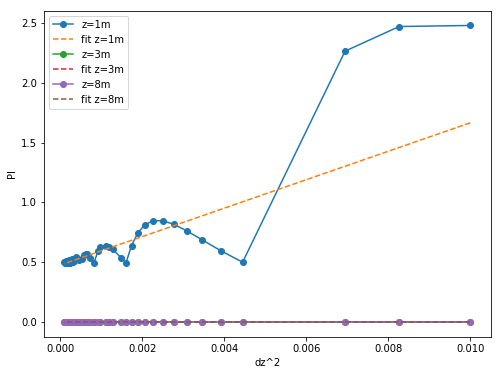

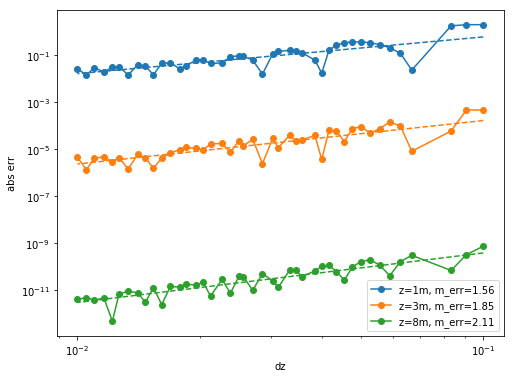

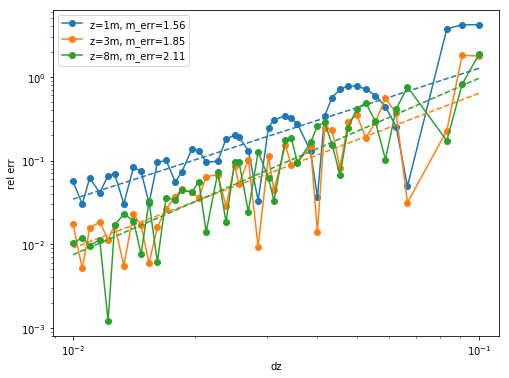

In [363]:
#norm = lambda x: np.linalg.norm(np.ravel(x), ord=2)
#norm = lambda x: np.sqrt(np.sum(x)**2/np.size(x))
norm = lambda x: np.mean(np.abs(x))

nz_list, = kelp_analyze.get_unique_vals(conn, study_name, ['nz'])

nz_arr = np.array(nz_list)

fig1 = plt.figure(1, figsize=[8,6])
fig2 = plt.figure(2, figsize=[8,6])
fig3 = plt.figure(3, figsize=[8,6])

pi_arr = np.zeros([len(nz_arr), 3])
flux_arr = np.zeros(len(nz_arr))


# For richardson extrapolation
dz_max1 = 5e-2

# For fitting errors
dz_max2 = 1e-1

for k, nz in enumerate(nz_arr):
    results_list = kelp_analyze.query_results(
        conn, study_name,
        nz=nz
    )

    flux = results_list[0]['flux'][:]
    pi_1 = results_list[0]['pi_1'][:]
    pi_3 = results_list[0]['pi_3'][:]
    pi_8 = results_list[0]['pi_8'][:]
    
    flux_arr[k] = flux
    pi_arr[k, :] = [pi_1, pi_3, pi_8]
    
dz_arr = 1/nz_arr

depths = [1, 3, 8]
inds1 = dz_arr<dz_max1
inds2 = dz_arr<dz_max2
for j, d in enumerate(depths):
    # Estimate true soln.
    plt.figure(1)
    #plt.plot(dz_arr, pi_arr[:,0], 'o-', label='z=1m')
    #plt.plot(dz_arr, pi_arr[:,1], 'o-', label='z=3m')
    plt.plot(dz_arr**2, pi_arr[:,j], 'o-', label='z={:d}m'.format(d))
    popt, pcov = curve_fit(lambda x, m, b: m*x+b, dz_arr[inds1]**2, pi_arr[inds1,j], p0=[0, 0])
    m, b = popt
    plt.plot(dz_arr**2, m*dz_arr**2+b, '--', label='fit z={:d}m'.format(d))
    print("b={:.2f}".format(b))
    best_err = np.abs(b-pi_arr[-1, j])
    best_rel = best_err / b
    print("best err = {:.2e}".format(best_err))
    print("best rel = {:.2e}".format(best_rel))
    
    abs_err_arr = np.abs(pi_arr[:,j] - b)
    rel_err_arr = np.abs(abs_err_arr/b)
    
    # Plot errors
    plt.figure(2)
    popt, pcov = curve_fit(lambda x, m, b: m*x+b, np.log(dz_arr[inds2]), np.log(abs_err_arr[inds2]), p0=[2, 0])
    m_err, b_err = popt
    plt.plot(dz_arr, abs_err_arr, 'C{}o-'.format(j), label='z={:d}m, m_err={:.2f}'.format(d, m_err))
    plt.plot(dz_arr, np.exp(b_err)*dz_arr**m_err, 'C{}--'.format(j))
    print("m_err(abs) = {:.2f}".format(m_err))
    
    # Plot errors
    plt.figure(3)
    popt, pcov = curve_fit(lambda x, m, b: m*x+b, np.log(dz_arr[inds2]), np.log(rel_err_arr[inds2]), p0=[2, 0])
    m_err, b_err = popt
    plt.plot(dz_arr, rel_err_arr, 'C{}o-'.format(j), label='z={:d}m, m_err={:.2f}'.format(d, m_err))
    plt.plot(dz_arr, np.exp(b_err)*dz_arr**m_err, 'C{}--'.format(j))
    print("m_err(rel) = {:.2f}".format(m_err))
    
plt.figure(1)
plt.title('')
plt.xlabel('dz^2')
plt.ylabel('PI')
plt.legend()

plt.figure(2)
plt.title('')
plt.legend()
plt.xlabel('dz')
plt.ylabel('abs err')
plt.xscale('log')
plt.yscale('log')

plt.figure(3)
plt.title('')
plt.legend()
plt.xlabel('dz')
plt.ylabel('rel err')
plt.xscale('log')
plt.yscale('log')

## 3D

### Compute

In [14]:
base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
# base_dir = '/home/oliver/academic/research/kelp-results'

na = 8
ns_list = np.logspace(1, 2, 11, base=10).astype(int)

study_name = 'verify_kelp_th_bad_abspt_ss_a05_b03_scat1_test_{}x{}_few'.format(max(ns_list), na)
study_dir = os.path.join(base_dir, study_name)

ntheta = na
nphi = na

# TODO: Don't actually delete results
shutil.rmtree(os.path.join(base_dir, study_name), ignore_errors=True)

num_scatters = 1
fd_flag = False

a_water = 0.5
b = 0
kelp_dist = 'top-heavy'

combine_thread, gs_fut = kelp_compute.verify_kelp_single_space_compute_scalar_metrics(
    study_name, 
    a_water, b, ns_list[::-1], na, 
    kelp_dist, num_scatters, 
    fd_flag, lis_opts=None, num_threads=None,
    base_dir=base_dir
)

Creating new study directory.
Reading existing runs.
Finished reading existing runs.
Running 11 new / 11 total requested tasks.
Opening combined db: /scratch/kelp-results/verify_kelp_th_bad_abspt_ss_a05_b03_scat1_test_100x8_few/verify_kelp_th_bad_abspt_ss_a05_b03_scat1_test_100x8_few.db
Connected.
Finished combining DBs.


### Plot

In [364]:
study_name = 'verify_kelp_th_bad_abspt_ss_a05_b03_scat1_test_100x8_few'
study_dir = os.path.join(base_dir, study_name)

In [365]:
print(study_name)
db_path = os.path.join(study_dir, '{}.db'.format(study_name))
conn = sqlite3.Connection(db_path)

verify_kelp_th_bad_abspt_ss_a05_b03_scat1_test_100x8_few


In [366]:
sm_dashboard(conn, study_name)

# Full Asym VoC

## Compute

In [28]:
d = np.diff(np.log10(b_list))[0]

In [31]:
d

0.07766333381511314

In [35]:
5e-1*10**(9*d)

2.499999999999997

In [36]:
b1 = b_list

In [54]:
b1

[0.1,
 0.11958131745004018,
 0.14299691483087287,
 0.17099759466766973,
 0.2044811765114791,
 0.2445212848097688,
 0.2924017738212866,
 0.3496578933827813,
 0.4181255154751867,
 0.5]

In [55]:
b_list = np.logspace(np.log10(5e-1), np.log10(2.5), 10)

In [56]:
c = np.concatenate([b1, b_list])

In [60]:
np.unique(c) - np.logspace(np.log10(1e-1), np.log10(2.5), 19)

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  5.55111512e-17,  0.00000000e+00, -1.11022302e-16,
        0.00000000e+00,  2.22044605e-16, -2.22044605e-16, -2.22044605e-16,
        2.22044605e-16,  4.44089210e-16,  0.00000000e+00])

In [53]:
np.concatenate([b1, b_list]) - np.logspace(np.log10(1e-1), np.log10(2.5), 20)

array([ 0.        ,  0.00112021,  0.00266657,  0.00476072,  0.00755513,
        0.01124051,  0.01605478,  0.02229419,  0.03032684,  0.04060939,
       -0.0441992 , -0.04675781, -0.04869202, -0.04967178, -0.04926408,
       -0.04690569, -0.04186924, -0.03322121, -0.0197697 ,  0.        ])

In [79]:
inds

array([False, False,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False])

In [115]:
base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
# base_dir = '/home/oliver/academic/research/kelp-results'

#ns_list = np.logspace(1, 2, 11, base=10).astype(int)[:-1] # Don't do ns=100 - too big
#ns_list = np.logspace(3, 7, base=2).astype(int)
ns_list = [8,16,32,48,64,72][::-1]
#b_list = np.logspace(-3.0, -1, 4)
#b_list = np.logspace(np.log10(1e-1), np.log10(5e-1), 10)
#b_list = np.logspace(np.log10(5e-1), np.log10(2.5), 10)[1:]
b_list = np.logspace(np.log10(1e-1), np.log10(2.5), 19)
num_scatters_list = [0, 1, 2, 3]

na = 10
a_water = 0.5
kelp_dist = 'top-heavy'
do_fd = True

num_threads = 32

study_name = 'verify_real_kelp_asym_b_scat_ss_sm_th_a05_br01_{}x{}'.format(max(ns_list), na)
study_dir = os.path.join(base_dir, study_name)

# TODO: Don't actually delete results
#shutil.rmtree(os.path.join(base_dir, study_name), ignore_errors=True)

combine_thread, gs_fut = kelp_compute.verify_kelp_asym_b_scat_ss_compute_scalar_metrics(
    study_name,
    ns_list, b_list, num_scatters_list,
    na, a_water, kelp_dist, do_fd, 
    fr=5.0, 
    absorptance_kelp=0.7,
    length_std=1.0,
    blur_radius=0.1,
    I0=50.0,
    decay=1.0,
    vsf_type='uniform', 
    lis_opts=None, num_threads=num_threads, 
    base_dir=base_dir,
    dry_run=False
)

Creating new study directory.
Reading existing runs.
Finished reading existing runs.
Running 570 new / 570 total requested tasks.


In [63]:
print("hi")

hi


## Plot

In [73]:
#study_name = 'verify_kelp_bad_abspt_asym_b_scat_ss_sm_th_a05_100x8'
#study_name = 'verify_kelp_better_abspt_std3_periodic_abs_asym_b_scat_ss_sm_th_a05_79x8'
#study_name = 'verify_nokelp_flat_asym_b_scat_ss_sm_th_a05_32x18'
#study_name = 'verify_real_kelp_asym_b_scat_ss_sm_th_a05_br01_72x10'
study_name = 'verify_real_kelp_asym_b_scat_ss_sm_th_a05_72x10'
base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
study_dir = os.path.join(base_dir, study_name)

In [74]:
print(study_name)
db_path = os.path.join(study_dir, '{}.db'.format(study_name))
conn = sqlite3.Connection(db_path)

verify_real_kelp_asym_b_scat_ss_sm_th_a05_72x10


# Rad err

In [75]:
### norm = lambda x: np.linalg.norm(np.ravel(x), ord=2)
#norm = lambda x: np.sqrt(np.sum(x)**2/np.size(x))
#norm = lambda x: np.mean(np.abs(x))
norm = lambda x: theano.tensor.mean(abs(x))

ns_list, b_list, num_scatters_list = kelp_analyze.get_unique_vals(conn, study_name, ['ns', 'b', 'num_scatters'])
num_scatters_list = [n for n in num_scatters_list if n >= 0]
ns_arr = theano.tensor._shared(np.array(ns_list[:-1])).eval()

depths = [1, 3, 8]
scalar_metrics = [
    ('flux', r'$\Phi$'),
    *[
        ('pi_{}'.format(d), 'PI (z={})'.format(d))
        for d in depths
    ]
]

# Just use flux for now
# TODO: Revert to flux
sm = scalar_metrics[0]

fd_sm_arr = np.zeros(len(ns_arr))
asym_sm_arr = np.zeros(len(ns_arr))

# For richardson extrapolation
ds_max1 = 0.5 #0.5 #0.2
# For fitting errors
ds_max2 = 0.65 #1.0 #0.5

# TODO: Fix ds
rope_spacing = 10
zmax = 10
ds_arr = (rope_spacing**2*zmax)**(1/3)/ns_arr
inds1 = ds_arr<=ds_max1
inds2 = ds_arr<=ds_max2

print("inds1 = {}".format(inds1))
print("inds2 = {}".format(inds2))

rel_err_arr = np.zeros([
    len(b_list),
    len(num_scatters_list),
    len(ns_arr)
])

tot_err_arr = np.zeros([
    len(b_list),
    len(num_scatters_list),
    len(ns_arr)
])

fd_time_arr = np.zeros([
    len(b_list),
    len(ns_arr)
])

asym_time_arr = np.zeros([
    len(b_list),
    len(num_scatters_list),
    len(ns_arr)
])

asym_r2_arr = np.zeros([
    len(b_list),
    len(num_scatters_list)
])

fd_r2_arr = np.zeros([
    len(b_list),
])

for j, b in enumerate(b_list):
    print()
    print("b={:.2e}".format(b))
    for k, ns in enumerate(ns_arr):
        fd_results_list = kelp_analyze.query_results(
            conn, study_name, base_dir,
            ns=ns,
            fd_flag=True,
            b=b,
        )
        #print(ns,True,num_scatters,b)
        #fd_sm_arr[k] = theano.tensor._shared(fd_results_list[0][sm[0]][:]).eval()
        fd_rad = theano.tensor._shared(fd_results_list[0]['rad'][:].data)
        
        # Compute time
        fd_compute_time = fd_results_list[0]['compute_time'][:].data
        fd_time_arr[j, k] = fd_compute_time
    # FD Richardson extrapolation
    fd_abs_err_arr, fd_rel_err_arr, fd_r2 = get_re_errs(ds_arr, fd_sm_arr, inds=inds1)
    fd_r2_arr[j] = fd_r2
        
    for i, num_scatters in enumerate(num_scatters_list):
        print("n={}".format(num_scatters))
        for k, ns in enumerate(ns_arr):
            asym_results_list = kelp_analyze.query_results(
                conn, study_name, base_dir,
                ns=ns,
                fd_flag=False,
                num_scatters=num_scatters,
                b=b
            )
            #print(ns,False,num_scatters,b)
            #asym_sm_arr[k] = asym_results_list[0][sm[0]][:]
            asym_rad = theano.tensor._shared(asym_results_list[0]['rad'][:].data)

            # Compute time
            asym_compute_time = asym_results_list[0]['compute_time'][:].data
            asym_time_arr[j, i, k] = asym_compute_time

        # Asym. Richardson extrapolation
        asym_abs_err_arr, asym_rel_err_arr, asym_r2 = get_re_errs(ds_arr, asym_sm_arr, inds=inds1)
        asym_r2_arr[j, i] = asym_r2
        
        tot_err = norm(asym_rad - fd_rad).eval()
        rel_err = norm((asym_rad - fd_rad)/fd_rad).eval()
        # Calculate difference between FD & asym.
        #sm_diff = np.abs(asym_sm_arr - fd_sm_arr[-1])
        # TODO: Un-zero errors
        #tot_err = (sm_diff + 1*(fd_abs_err_arr[-1] + asym_abs_err_arr)) / fd_sm_arr[-1]
        #print("best errs: fd={:.4e} | asym={:.4e} | diff={:.4e}".format(fd_abs_err_arr[-1], asym_abs_err_arr[-1], sm_diff[-1]))
        print("tot err = {}".format(tot_err))
        print("rel err = {}".format(rel_err))
        #print("mean rad: {}".format(np.mean(fd_rad)))
        print()
        tot_err_arr[j, i, :] = tot_err
        rel_err_arr[j, i, :] = rel_err

inds1 = [False False  True  True  True]
inds2 = [False  True  True  True  True]

b=1.00e-01
n=0
tot err = 0.01868479121093409
rel err = 0.873155691106894

n=1
tot err = 0.004654921326274852
rel err = 0.5361605553113825

n=2
tot err = 0.0037361168481439204
rel err = 0.36237586662312804

n=3
tot err = 0.0037428070585208855
rel err = 0.24569888351836092


b=1.20e-01
n=0
tot err = 0.02193519335139003
rel err = 0.8824800842185171

n=1
tot err = 0.005110244927881424
rel err = 0.6407097721156496

n=2
tot err = 0.003748862174479857
rel err = 0.4514359669912525

n=3
tot err = 0.0037523224694720417
rel err = 0.28699469601493266


b=1.43e-01
n=0
tot err = 0.02573208255288701
rel err = 0.8955112799982468

n=1
tot err = 0.005776505007935436
rel err = 0.7883277960365273

n=2
tot err = 0.003776642718794725
rel err = 0.5992123679890704

n=3
tot err = 0.003769017542018334
rel err = 0.3739719394690907


b=1.71e-01
n=0
tot err = 0.03014213563037148
rel err = 0.9140436975677949

n=1
tot err = 0.0067408090

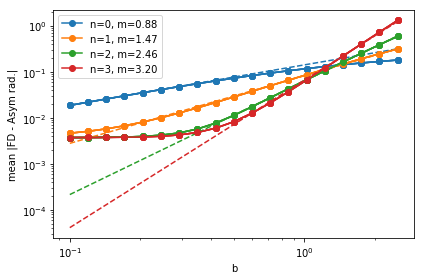

In [83]:
plt.figure(figsize=(6,4))
for k, ns in enumerate(ns_arr):
    for i, num_scatters in enumerate(num_scatters_list):
        alpha = ((k+1)/len(ns_arr))
        plt.plot(np.array(b_list), tot_err_arr[:,i, k], 'C{}o-'.format(i), alpha=alpha)
        #plt.plot(b_list, np.exp(b_err)*np.array(b_list)**m_err, 'C{}--'.format(i), alpha=alpha)
        #plt.scatter(b_list, tot_err_arr[:,i, k], c='C{}'.format(i), s=1000*(1-asym_r2_arr[:,i]), alpha=alpha)
k=len(ns_arr)-1
alpha = (k+1)/len(ns_arr)
reg_lims = [
    [1e-2, 3e-1],
    [1e-1, 6e-0],
    [4e-1, 6e-0],
    [4e-1, 6e-0]
]
b_arr = np.array(b_list)
for i, num_scatters in enumerate(num_scatters_list):
    inds = np.logical_and(
        b_arr > reg_lims[i][0],
        b_arr < reg_lims[i][1]
    )
    m_err, b_err = robust_exp_regression(b_arr[inds], tot_err_arr[inds, i, k])
    plt.plot(np.array(b_list), tot_err_arr[:,i, k], 'C{}o-'.format(i), label='n={}, m={:.2f}'.format(num_scatters, m_err),alpha=alpha)
    plt.plot(np.array(b_list), np.exp(b_err)*np.array(b_list)**m_err, 'C{}--'.format(i), alpha=alpha)
    #plt.scatter(b_list, tot_err_arr[:,i, k], c='C{}'.format(i), s=1000*(1-asym_r2_arr[:,i]), alpha=alpha)
plt.legend()
plt.xlabel('b')
plt.ylabel('mean |FD - Asym rad.|')
plt.yscale('log')
plt.xscale('log')
#plt.xlim(1e-4,1e-0)
#plt.ylim(1e-5,2e0)
plt.tight_layout()
plt.savefig('/scratch/kelp-figures/{}_rad_err.pdf'.format(study_name))

# Compute Time

In [76]:
ds_arr

array([1.25      , 0.625     , 0.3125    , 0.20833333, 0.15625   ])

In [85]:
asym_time_arr.shape

(19, 4, 5)

In [86]:
fd_time_arr.shape

(19, 5)

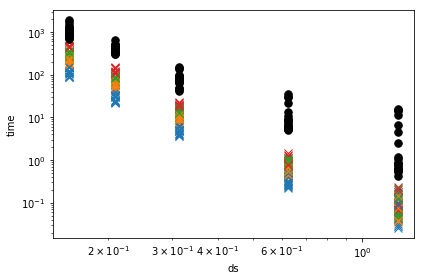

In [93]:
plt.figure(figsize=(6, 4))
for j, b in enumerate(b_arr):
    pcnt = (np.log(b)-np.log(b_arr.min())) / (np.log(b_arr.max())-np.log(b_arr.min()))
    #plt.plot(ds_arr, asym_time_arr[j, :], color=mpl.cm.plasma(pcnt), label='b={:.2f}'.format(b))
    plt.plot(ds_arr, fd_time_arr[j, :], 'ko', ms=7.5, label='FD')
    for k, num_scatters in enumerate(num_scatters_list):
        plt.plot(ds_arr, asym_time_arr[j, k, :], 'C{}x'.format(k), ms=7.5, label='Asym. n={}'.format(num_scatters))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('ds')
plt.ylabel('time')
#plt.xlim(1e-4, 2e-1)
#plt.ylim(3e1, 1e3)
#plt.legend(bbox_to_anchor=(1.05,1.0))
plt.tight_layout()
#plt.savefig('/scratch/kelp-figures/mms_asym_err_time.pdf')

In [95]:
import seaborn as sns

In [100]:
import pandas as pd

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


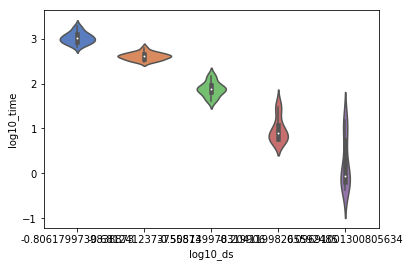

In [164]:
fd_ds_col = np.repeat([[ds_arr]], 19, 0).ravel()
fd_time_col = fd_time_arr.ravel()
fd_time_df = pd.DataFrame(np.vstack([ds_col, np.log10(ds_col), fd_time_col, np.log10(fd_time_col)]).T, columns=['ds', 'log10_ds', 'time', 'log10_time'])

sns.violinplot(x='log10_ds', y='log10_time', data=fd_time_df, palette='muted')

In [165]:
asym_b_col = np.broadcast_to(b_arr.reshape(-1,1,1), asym_time_arr.shape).ravel()
asym_num_scatters_col = np.broadcast_to(np.reshape(num_scatters_list, (1,-1,1)), asym_time_arr.shape).ravel()
asym_ds_col = np.broadcast_to(ds_arr.reshape(1,1,-1), asym_time_arr.shape).ravel()

In [200]:
asym_time_df.dtypes

b               float64
num_scatters    float64
ds              float64
log10_ds        float64
time            float64
log10_time      float64
dtype: object

In [206]:
>>> df = pd.DataFrame({'float': [1.0],
...                    'int': [1],
...                    'datetime': [pd.Timestamp('20180310')],
...                    'string': ['foo']})

In [207]:
pd.DataFrame.dtypes

,float,int,datetime,string
0,1.0,1,2018-03-10,foo


In [214]:
asym_time_df = pd.DataFrame(
    {
        'b': asym_b_col, 
        'num_scatters': asym_num_scatters_col,
        'ds': asym_ds_col, 
        'log10_ds': np.log10(asym_ds_col), 
        'time': asym_time_arr.ravel(), 
        'log10_time': np.log10(asym_time_arr.ravel())
    },
    columns=['b', 'num_scatters', 'ds', 'log10_ds', 'time', 'log10_time'],
)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


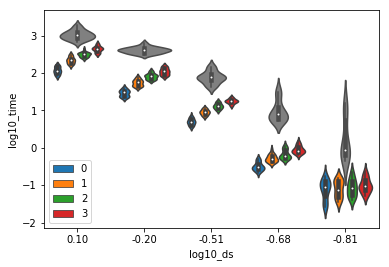

In [223]:
plt.figure(figsize=(6,4))
sns.violinplot(x='log10_ds', y='log10_time', data=fd_time_df, color='0.5')
sns.violinplot(x='log10_ds', y='log10_time', data=asym_time_df, hue='num_scatters', saturation=1, legend=False)
plt.xticks(range(5), ['{:.2f}'.format(x) for x in np.log10(ds_arr)])
plt.legend(loc='lower left')
plt.savefig('/scratch/kelp-figures/compute_time_violin.pdf')

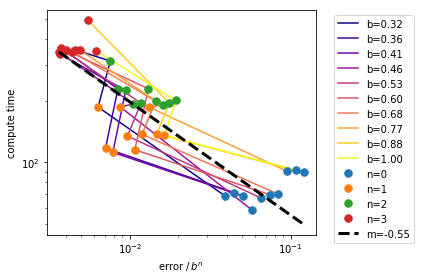

In [197]:
plt.figure(figsize=(6, 4))
b2d = b_arr.reshape(-1, 1)
n2d = np.array(num_scatters_list).reshape(1, -1)
xq = asym_err_arr / b2d**n2d
yq = asym_time_arr
m_lin, b_lin = conv.lin_fit(np.ravel(np.log(xq)), np.ravel(np.log(yq)), np.log(1e-3), np.log(1e-1))
for i, b in enumerate(b_arr):
    pcnt = (np.log(b)-np.log(b_arr.min())) / (np.log(b_arr.max())-np.log(b_arr.min()))
    plt.plot(xq[i,:], yq[i,:], color=cm.plasma(pcnt), label='b={:.2f}'.format(b))
for k, num_scatters in enumerate(num_scatters_list):
    plt.plot(xq[:,k], yq[:,k], 'C{}o'.format(k), ms=7.5, label='n={}'.format(num_scatters))
    
plt.plot(np.array([xq.min(), xq.max()]), np.exp(b_lin)*np.array([xq.min(), xq.max()])**m_lin, 'k--', lw=3, label='m={:.2f}'.format(m_lin))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'error $/\,b^n$')
plt.ylabel('compute time')
#plt.xlim(1e-4, 2e-1)
#plt.ylim(3e1, 1e3)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.tight_layout()
plt.savefig('/scratch/kelp-figures/mms_asym_err_time_collapsed.pdf')

# Compare Models

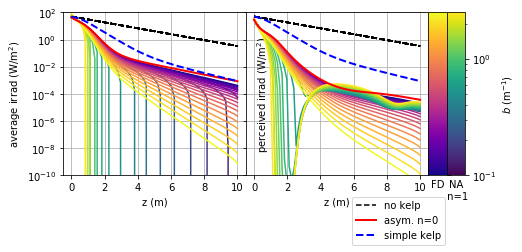

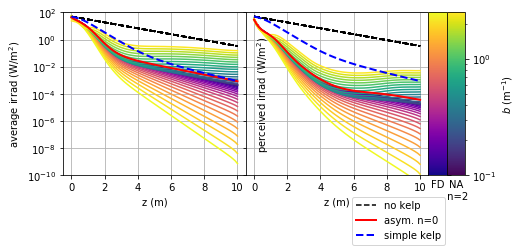

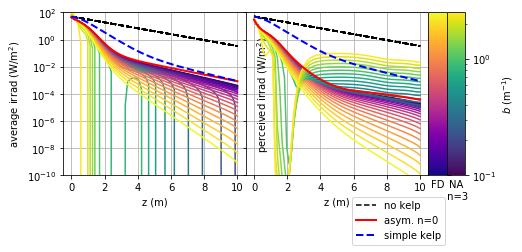

In [232]:
ns_list, b_list, num_scatters_list = kelp_analyze.get_unique_vals(conn, study_name, ['ns', 'b', 'num_scatters'])
b_arr = np.array(b_list)

noscat_results = kelp_analyze.query_results(
    conn, study_name, base_dir,
    ns=max(ns_list),
    fd_flag=False,
    num_scatters=0,
)
noscat_irrad = noscat_results[0]['irrad'][:].data
noscat_avg_irrad = np.mean(noscat_irrad, axis=(0,1))
noscat_perc_irrad = noscat_results[0]['perceived_irrad'][:].data

zmax = noscat_results[0]['zmax'][:].data
nz = max(ns_list)
z = np.linspace(0, zmax, nz) 
a_water = noscat_results[0]['a_water'][:].data
I0 = noscat_results[0]['I0'][:].data
fr = noscat_results[0]['fr'][:].data
absorptance_kelp = noscat_results[0]['absorptance_kelp'][:].data
rope_spacing = noscat_results[0]['rope_spacing'][:].data
num_dens = noscat_results[0]['num_dens'][:].data
max_length = noscat_results[0]['max_length'][:].data

# Ole Jacob's model
frond_lengths = max_length * (3*z**2 * np.exp(-z) + 0.5) / (12*np.exp(-2)+0.5)
A = frond_lengths**2 / (2*fr)
D = 1/rope_spacing**2
k_kelp = -np.log(1-absorptance_kelp*(1-(1-A*D)**num_dens))
expnt = -np.concatenate([[0], integrate.cumtrapz((a_water+k_kelp), z)])
oj_irrad = I0 * np.exp(expnt)

for k, num_scatters in enumerate(num_scatters_list[1:]):
    fig = plt.figure(k, figsize=(6*6/5, 3))
    m=10
    ax1 = plt.subplot2grid((1, 2*m+2), (0, 0), colspan=m)
    ax2 = plt.subplot2grid((1, 2*m+2), (0, m), colspan=m)
    ax3 = plt.subplot2grid((1, 2*m+2), (0, 2*m), colspan=1)
    color_norm = mpl.colors.LogNorm(vmin=np.min(b_list), vmax=np.max(b_list))
    cb1 = mpl.colorbar.ColorbarBase(
        ax3, cmap=mpl.cm.plasma,
        norm=color_norm,
        orientation='vertical',
    )
    ax3.set_xlabel("FD")
    ax4 = plt.subplot2grid((1, 2*m+2), (0, 2*m+1), colspan=1, sharey=ax3)
    ax4.set_xlabel("NA\n n={}".format(num_scatters))
    plt.setp(ax2.get_yticklabels(), visible=False)
    plt.setp(ax3.get_yticklabels(), visible=False)
    fig.subplots_adjust(wspace=0)
    cb2 = mpl.colorbar.ColorbarBase(
        ax4, cmap=mpl.cm.viridis,
        norm=color_norm,
        orientation='vertical',
    )
    ax1.grid()
    ax2.grid()
    cb2.set_label("$b$ (m$^{-1}$)")

    for b in b_list:
        fd_results = kelp_analyze.query_results(
            conn, study_name, base_dir,
            ns=max(ns_list),
            fd_flag=True,
            num_scatters=0,
            b=b
        )

        asym_results = kelp_analyze.query_results(
            conn, study_name, base_dir,
            ns=max(ns_list),
            fd_flag=False,
            num_scatters=num_scatters,
            b=b
        )

        pcnt = (np.log(b)-np.log(b_arr.min())) / (np.log(b_arr.max())-np.log(b_arr.min()))

        fd_irrad = fd_results[0]['irrad'][:].data
        fd_avg_irrad = np.mean(fd_irrad, axis=(0,1))
        fd_perc_irrad = fd_results[0]['perceived_irrad'][:].data
        asym_irrad = asym_results[0]['irrad'][:].data
        asym_avg_irrad = np.mean(asym_irrad, axis=(0,1))
        asym_perc_irrad = asym_results[0]['perceived_irrad'][:].data

        ax1.plot(z, fd_avg_irrad, '-', color=mpl.cm.plasma(pcnt))
        ax1.plot(z, I0*np.exp(-a_water*z), 'k--')
        ax2.plot(z, fd_perc_irrad, '-', color=mpl.cm.plasma(pcnt))
        ax2.plot(z, I0*np.exp(-a_water*z), 'k--')

        ax1.plot(z, asym_avg_irrad, '-', color=mpl.cm.viridis(pcnt))
        ax2.plot(z, asym_perc_irrad, '-', color=mpl.cm.viridis(pcnt))

    ax1.plot(z, I0*np.exp(-a_water*z), 'k--')
    ax2.plot(z, I0*np.exp(-a_water*z), 'k--', label='no kelp')

    ax1.plot(z, noscat_avg_irrad, 'r-', lw=2)
    ax2.plot(z, noscat_perc_irrad, 'r-', lw=2, label='asym. n=0')
    ax1.plot(z, oj_irrad, 'b--', lw=2)
    ax2.plot(z, oj_irrad, 'b--', lw=2, label='simple kelp')

    ax1.set_yscale('log')
    ax1.set_xlabel('z (m)')
    ax1.set_ylabel('average irrad (W/m$^2$)')
    ax1.set_ylim(1e-10, 1e2)

    ax2.set_yscale('log')
    ax2.set_xlabel('z (m)')
    ax2.set_ylabel('perceived irrad (W/m$^2$)', labelpad=-25)
    ax2.set_ylim(1e-10, 1e2)

    plt.sca(ax2)
    #lgd = plt.legend(loc='upper left', bbox_to_anchor=(1.35,1))
    lgd = plt.legend(loc='upper right', bbox_to_anchor=(1.12,-0.1))
    plt.savefig(
        '/scratch/kelp-figures/compare_models_n{}.pdf'.format(num_scatters), 
        bbox_extra_artists=(lgd,), 
        bbox_inches='tight'
    )
    

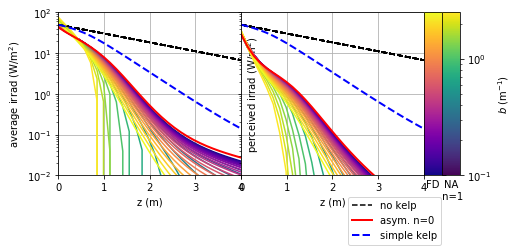

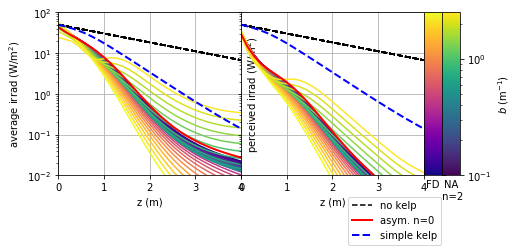

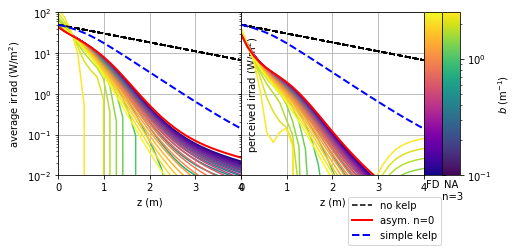

In [230]:
ns_list, b_list, num_scatters_list = kelp_analyze.get_unique_vals(conn, study_name, ['ns', 'b', 'num_scatters'])
b_arr = np.array(b_list)

noscat_results = kelp_analyze.query_results(
    conn, study_name, base_dir,
    ns=max(ns_list),
    fd_flag=False,
    num_scatters=0,
)
noscat_irrad = noscat_results[0]['irrad'][:].data
noscat_avg_irrad = np.mean(noscat_irrad, axis=(0,1))
noscat_perc_irrad = noscat_results[0]['perceived_irrad'][:].data

zmax = noscat_results[0]['zmax'][:].data
nz = max(ns_list)
z = np.linspace(0, zmax, nz) 
a_water = noscat_results[0]['a_water'][:].data
I0 = noscat_results[0]['I0'][:].data
fr = noscat_results[0]['fr'][:].data
absorptance_kelp = noscat_results[0]['absorptance_kelp'][:].data
rope_spacing = noscat_results[0]['rope_spacing'][:].data
num_dens = noscat_results[0]['num_dens'][:].data
max_length = noscat_results[0]['max_length'][:].data

# Ole Jacob's model
frond_lengths = max_length * (3*z**2 * np.exp(-z) + 0.5) / (12*np.exp(-2)+0.5)
A = frond_lengths**2 / (2*fr)
D = 1/rope_spacing**2
k_kelp = -np.log(1-absorptance_kelp*(1-(1-A*D)**num_dens))
expnt = -np.concatenate([[0], integrate.cumtrapz((a_water+k_kelp), z)])
oj_irrad = I0 * np.exp(expnt)

for k, num_scatters in enumerate(num_scatters_list[1:]):
    fig = plt.figure(k, figsize=(6*6/5, 3))
    m=10
    ax1 = plt.subplot2grid((1, 2*m+2), (0, 0), colspan=m)
    ax2 = plt.subplot2grid((1, 2*m+2), (0, m), colspan=m)
    ax3 = plt.subplot2grid((1, 2*m+2), (0, 2*m), colspan=1)
    color_norm = mpl.colors.LogNorm(vmin=np.min(b_list), vmax=np.max(b_list))
    cb1 = mpl.colorbar.ColorbarBase(
        ax3, cmap=mpl.cm.plasma,
        norm=color_norm,
        orientation='vertical',
    )
    ax3.set_xlabel("FD")
    ax4 = plt.subplot2grid((1, 2*m+2), (0, 2*m+1), colspan=1, sharey=ax3)
    ax4.set_xlabel("NA\n n={}".format(num_scatters))
    plt.setp(ax2.get_yticklabels(), visible=False)
    plt.setp(ax3.get_yticklabels(), visible=False)
    fig.subplots_adjust(wspace=0)
    cb2 = mpl.colorbar.ColorbarBase(
        ax4, cmap=mpl.cm.viridis,
        norm=color_norm,
        orientation='vertical',
    )
    ax1.grid()
    ax2.grid()
    cb2.set_label("$b$ (m$^{-1}$)")

    for b in b_list:
        fd_results = kelp_analyze.query_results(
            conn, study_name, base_dir,
            ns=max(ns_list),
            fd_flag=True,
            num_scatters=0,
            b=b
        )

        asym_results = kelp_analyze.query_results(
            conn, study_name, base_dir,
            ns=max(ns_list),
            fd_flag=False,
            num_scatters=num_scatters,
            b=b
        )

        pcnt = (np.log(b)-np.log(b_arr.min())) / (np.log(b_arr.max())-np.log(b_arr.min()))

        fd_irrad = fd_results[0]['irrad'][:].data
        fd_avg_irrad = np.mean(fd_irrad, axis=(0,1))
        fd_perc_irrad = fd_results[0]['perceived_irrad'][:].data
        asym_irrad = asym_results[0]['irrad'][:].data
        asym_avg_irrad = np.mean(asym_irrad, axis=(0,1))
        asym_perc_irrad = asym_results[0]['perceived_irrad'][:].data

        ax1.plot(z, fd_avg_irrad, '-', color=mpl.cm.plasma(pcnt))
        ax1.plot(z, I0*np.exp(-a_water*z), 'k--')
        ax2.plot(z, fd_perc_irrad, '-', color=mpl.cm.plasma(pcnt))
        ax2.plot(z, I0*np.exp(-a_water*z), 'k--')

        ax1.plot(z, asym_avg_irrad, '-', color=mpl.cm.viridis(pcnt))
        ax2.plot(z, asym_perc_irrad, '-', color=mpl.cm.viridis(pcnt))

    ax1.plot(z, I0*np.exp(-a_water*z), 'k--')
    ax2.plot(z, I0*np.exp(-a_water*z), 'k--', label='no kelp')

    ax1.plot(z, noscat_avg_irrad, 'r-', lw=2)
    ax2.plot(z, noscat_perc_irrad, 'r-', lw=2, label='asym. n=0')
    ax1.plot(z, oj_irrad, 'b--', lw=2)
    ax2.plot(z, oj_irrad, 'b--', lw=2, label='simple kelp')

    ax1.set_yscale('log')
    ax1.set_xlabel('z (m)')
    ax1.set_ylabel('average irrad (W/m$^2$)')
    ax1.set_xlim(0, 4)
    ax1.set_ylim(1e-2, 1e2)

    ax2.set_yscale('log')
    ax2.set_xlabel('z (m)')
    ax2.set_ylabel('perceived irrad (W/m$^2$)', labelpad=-25)
    ax2.set_xlim(0, 4)
    ax2.set_ylim(1e-2, 1e2)

    plt.sca(ax2)
    #lgd = plt.legend(loc='upper left', bbox_to_anchor=(1.35,1))
    lgd = plt.legend(loc='upper right', bbox_to_anchor=(1.12,-0.1))
    plt.savefig(
        '/scratch/kelp-figures/compare_models_n{}_zoom.pdf'.format(num_scatters), 
        bbox_extra_artists=(lgd,), 
        bbox_inches='tight'
    )
    

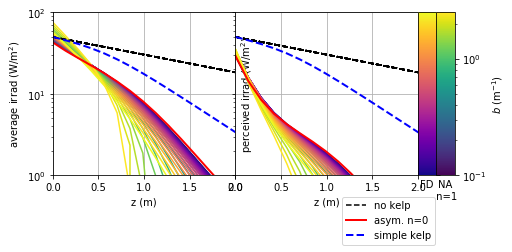

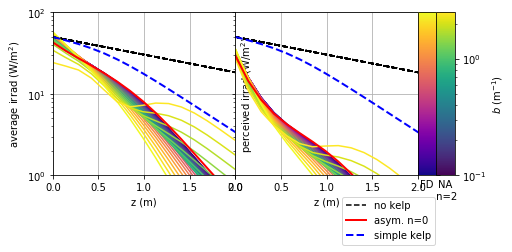

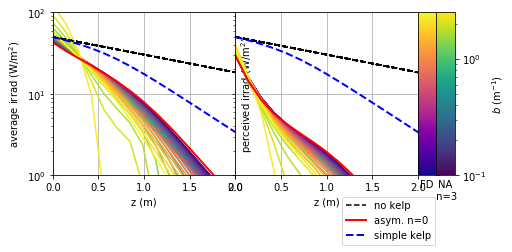

In [231]:
ns_list, b_list, num_scatters_list = kelp_analyze.get_unique_vals(conn, study_name, ['ns', 'b', 'num_scatters'])
b_arr = np.array(b_list)

noscat_results = kelp_analyze.query_results(
    conn, study_name, base_dir,
    ns=max(ns_list),
    fd_flag=False,
    num_scatters=0,
)
noscat_irrad = noscat_results[0]['irrad'][:].data
noscat_avg_irrad = np.mean(noscat_irrad, axis=(0,1))
noscat_perc_irrad = noscat_results[0]['perceived_irrad'][:].data

zmax = noscat_results[0]['zmax'][:].data
nz = max(ns_list)
z = np.linspace(0, zmax, nz) 
a_water = noscat_results[0]['a_water'][:].data
I0 = noscat_results[0]['I0'][:].data
fr = noscat_results[0]['fr'][:].data
absorptance_kelp = noscat_results[0]['absorptance_kelp'][:].data
rope_spacing = noscat_results[0]['rope_spacing'][:].data
num_dens = noscat_results[0]['num_dens'][:].data
max_length = noscat_results[0]['max_length'][:].data

# Ole Jacob's model
frond_lengths = max_length * (3*z**2 * np.exp(-z) + 0.5) / (12*np.exp(-2)+0.5)
A = frond_lengths**2 / (2*fr)
D = 1/rope_spacing**2
k_kelp = -np.log(1-absorptance_kelp*(1-(1-A*D)**num_dens))
expnt = -np.concatenate([[0], integrate.cumtrapz((a_water+k_kelp), z)])
oj_irrad = I0 * np.exp(expnt)

for k, num_scatters in enumerate(num_scatters_list[1:]):
    fig = plt.figure(k, figsize=(6*6/5, 3))
    m=10
    ax1 = plt.subplot2grid((1, 2*m+2), (0, 0), colspan=m)
    ax2 = plt.subplot2grid((1, 2*m+2), (0, m), colspan=m)
    ax3 = plt.subplot2grid((1, 2*m+2), (0, 2*m), colspan=1)
    color_norm = mpl.colors.LogNorm(vmin=np.min(b_list), vmax=np.max(b_list))
    cb1 = mpl.colorbar.ColorbarBase(
        ax3, cmap=mpl.cm.plasma,
        norm=color_norm,
        orientation='vertical',
    )
    ax3.set_xlabel("FD")
    ax4 = plt.subplot2grid((1, 2*m+2), (0, 2*m+1), colspan=1, sharey=ax3)
    ax4.set_xlabel("NA\n n={}".format(num_scatters))
    plt.setp(ax2.get_yticklabels(), visible=False)
    plt.setp(ax3.get_yticklabels(), visible=False)
    fig.subplots_adjust(wspace=0)
    cb2 = mpl.colorbar.ColorbarBase(
        ax4, cmap=mpl.cm.viridis,
        norm=color_norm,
        orientation='vertical',
    )
    ax1.grid()
    ax2.grid()
    cb2.set_label("$b$ (m$^{-1}$)")

    for b in b_list:
        fd_results = kelp_analyze.query_results(
            conn, study_name, base_dir,
            ns=max(ns_list),
            fd_flag=True,
            num_scatters=0,
            b=b
        )

        asym_results = kelp_analyze.query_results(
            conn, study_name, base_dir,
            ns=max(ns_list),
            fd_flag=False,
            num_scatters=num_scatters,
            b=b
        )

        pcnt = (np.log(b)-np.log(b_arr.min())) / (np.log(b_arr.max())-np.log(b_arr.min()))

        fd_irrad = fd_results[0]['irrad'][:].data
        fd_avg_irrad = np.mean(fd_irrad, axis=(0,1))
        fd_perc_irrad = fd_results[0]['perceived_irrad'][:].data
        asym_irrad = asym_results[0]['irrad'][:].data
        asym_avg_irrad = np.mean(asym_irrad, axis=(0,1))
        asym_perc_irrad = asym_results[0]['perceived_irrad'][:].data

        ax1.plot(z, fd_avg_irrad, '-', color=mpl.cm.plasma(pcnt))
        ax1.plot(z, I0*np.exp(-a_water*z), 'k--')
        ax2.plot(z, fd_perc_irrad, '-', color=mpl.cm.plasma(pcnt))
        ax2.plot(z, I0*np.exp(-a_water*z), 'k--')

        ax1.plot(z, asym_avg_irrad, '-', color=mpl.cm.viridis(pcnt))
        ax2.plot(z, asym_perc_irrad, '-', color=mpl.cm.viridis(pcnt))

    ax1.plot(z, I0*np.exp(-a_water*z), 'k--')
    ax2.plot(z, I0*np.exp(-a_water*z), 'k--', label='no kelp')

    ax1.plot(z, noscat_avg_irrad, 'r-', lw=2)
    ax2.plot(z, noscat_perc_irrad, 'r-', lw=2, label='asym. n=0')
    ax1.plot(z, oj_irrad, 'b--', lw=2)
    ax2.plot(z, oj_irrad, 'b--', lw=2, label='simple kelp')

    ax1.set_yscale('log')
    ax1.set_xlabel('z (m)')
    ax1.set_ylabel('average irrad (W/m$^2$)')
    ax1.set_xlim(0, 2)
    ax1.set_ylim(1e0, 1e2)

    ax2.set_yscale('log')
    ax2.set_xlabel('z (m)')
    ax2.set_ylabel('perceived irrad (W/m$^2$)', labelpad=-25)
    ax2.set_xlim(0, 2)
    ax2.set_ylim(1e0, 1e2)

    plt.sca(ax2)
    #lgd = plt.legend(loc='upper left', bbox_to_anchor=(1.35,1))
    lgd = plt.legend(loc='upper right', bbox_to_anchor=(1.12,-0.1))
    plt.savefig(
        '/scratch/kelp-figures/compare_models_n{}_zoom2.pdf'.format(num_scatters), 
        bbox_extra_artists=(lgd,), 
        bbox_inches='tight'
    )
    

# Flux SM

In [69]:
### norm = lambda x: np.linalg.norm(np.ravel(x), ord=2)
#norm = lambda x: np.sqrt(np.sum(x)**2/np.size(x))
#norm = lambda x: np.mean(np.abs(x))
norm = lambda x: theano.tensor.mean(abs(x))

ns_list, b_list, num_scatters_list = kelp_analyze.get_unique_vals(conn, study_name, ['ns', 'b', 'num_scatters'])
num_scatters_list = [n for n in num_scatters_list if n >= 0]
ns_arr = theano.tensor._shared(np.array(ns_list)).eval()

depths = [1, 3, 8]
scalar_metrics = [
    ('flux', r'$\Phi$'),
    *[
        ('pi_{}'.format(d), 'PI (z={})'.format(d))
        for d in depths
    ]
]

# Just use flux for now
# TODO: Revert to flux
sm = scalar_metrics[0]

fd_sm_arr = np.zeros(len(ns_arr))
asym_sm_arr = np.zeros(len(ns_arr))

# For richardson extrapolation
ds_max1 = 0.5 #0.5 #0.2
# For fitting errors
ds_max2 = 0.65 #1.0 #0.5

# TODO: Fix ds
rope_spacing = 10
zmax = 10
ds_arr = (rope_spacing**2*zmax)**(1/3)/ns_arr
inds1 = ds_arr<=ds_max1
inds2 = ds_arr<=ds_max2

print("inds1 = {}".format(inds1))
print("inds2 = {}".format(inds2))

rel_err_arr = np.zeros([
    len(b_list),
    len(num_scatters_list),
    len(ns_arr)
])

tot_err_arr = np.zeros([
    len(b_list),
    len(num_scatters_list),
    len(ns_arr)
])

asym_r2_arr = np.zeros([
    len(b_list),
    len(num_scatters_list)
])

fd_r2_arr = np.zeros([
    len(b_list),
])

for j, b in enumerate(b_list):
    print()
    print("b={:.2e}".format(b))
    for k, ns in enumerate(ns_arr):
        fd_results_list = kelp_analyze.query_results(
            conn, study_name, base_dir,
            ns=ns,
            fd_flag=True,
            b=b,
        )
        #print(ns,True,num_scatters,b)
        fd_sm_arr[k] = theano.tensor._shared(fd_results_list[0][sm[0]][:]).eval()
        fd_rad = theano.tensor._shared(fd_results_list[0]['rad'][:].data)
        
    # FD Richardson extrapolation
    fd_abs_err_arr, fd_rel_err_arr, fd_r2 = get_re_errs(ds_arr, fd_sm_arr, inds=inds1)
    fd_r2_arr[j] = fd_r2
        
    for i, num_scatters in enumerate(num_scatters_list):
        print("n={}".format(num_scatters))
        for k, ns in enumerate(ns_arr):
            asym_results_list = kelp_analyze.query_results(
                conn, study_name, base_dir,
                ns=ns,
                fd_flag=False,
                num_scatters=num_scatters,
                b=b
            )
            #print(ns,False,num_scatters,b)
            asym_sm_arr[k] = asym_results_list[0][sm[0]][:]
            asym_rad = theano.tensor._shared(asym_results_list[0]['rad'][:].data)

        # Asym. Richardson extrapolation
        asym_abs_err_arr, asym_rel_err_arr, asym_r2 = get_re_errs(ds_arr, asym_sm_arr, inds=inds1)
        asym_r2_arr[j, i] = asym_r2
        
        #tot_err = norm(asym_rad - fd_rad).eval()
        #rel_err = norm((asym_rad - fd_rad)/fd_rad).eval()
        # Calculate difference between FD & asym.
        sm_diff = np.abs(asym_sm_arr - fd_sm_arr[-1])
        # TODO: Un-zero errors
        tot_err = (sm_diff + 1*(fd_abs_err_arr[-1] + asym_abs_err_arr)) / fd_sm_arr[-1]
        #print("best errs: fd={:.4e} | asym={:.4e} | diff={:.4e}".format(fd_abs_err_arr[-1], asym_abs_err_arr[-1], sm_diff[-1]))
        print("tot err = {}".format(tot_err))
        print("rel err = {}".format(rel_err))
        #print("mean rad: {}".format(np.mean(fd_rad)))
        print()
        tot_err_arr[j, i, :] = tot_err
        #rel_err_arr[j, i, :] = rel_err

inds1 = [False False  True  True  True  True]
inds2 = [False  True  True  True  True  True]

b=1.00e-01
n=0
tot err = [1.2538524  0.64321844 0.20767924 0.0927076  0.04660915 0.0332919 ]
rel err = mean

n=1
tot err = [1.2303901  0.6666049  0.25025233 0.13983228 0.09547609 0.08265211]
rel err = mean

n=2
tot err = [1.2316008  0.6652599  0.24781556 0.13717076 0.09273601 0.07989111]
rel err = mean

n=3
tot err = [1.2315259  0.66533113 0.24795285 0.13732172 0.09289147 0.08004775]
rel err = mean


b=1.20e-01
n=0
tot err = [1.2559052  0.6401572  0.20097037 0.08503584 0.03855132 0.02512253]
rel err = mean

n=1
tot err = [1.2276121  0.66835676 0.25230607 0.14186007 0.09747629 0.08464245]
rel err = mean

n=2
tot err = [1.22935942 0.66641778 0.24879271 0.13802234 0.09352544 0.08066126]
rel err = mean

n=3
tot err = [1.22923025 0.66654061 0.24902905 0.13828253 0.09379351 0.0809313 ]
rel err = mean


b=1.43e-01
n=0
tot err = [1.25834832 0.63650962 0.19297855 0.07589725 0.03297765 0.03297765]
rel er

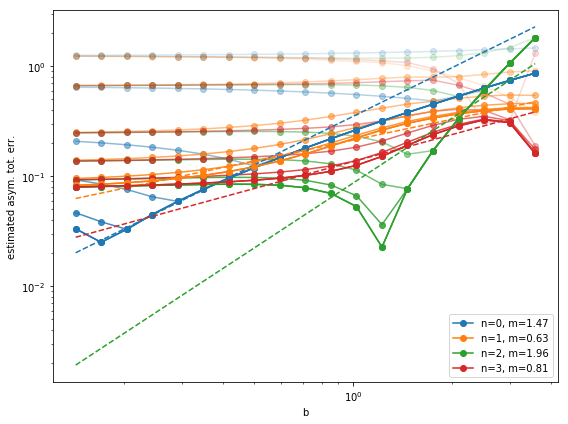

In [70]:
plt.figure(figsize=(8,6))
a_w = 0.7
for k, ns in enumerate(ns_arr):
    for i, num_scatters in enumerate(num_scatters_list):
        alpha = ((k+1)/len(ns_arr))
        plt.plot(np.array(b_list)/a_w, tot_err_arr[:,i, k], 'C{}o-'.format(i), alpha=alpha)
        #plt.plot(b_list, np.exp(b_err)*np.array(b_list)**m_err, 'C{}--'.format(i), alpha=alpha)
        #plt.scatter(b_list, tot_err_arr[:,i, k], c='C{}'.format(i), s=1000*(1-asym_r2_arr[:,i]), alpha=alpha)
k=len(ns_arr)-1
alpha = (k+1)/len(ns_arr)
reg_lims = [
    [1e-2, 3e-1],
    [1e-1, 6e-0],
    [4e-1, 6e-0],
    [4e-1, 6e-0]
]
b_arr = np.array(b_list)
for i, num_scatters in enumerate(num_scatters_list):
    inds = np.logical_and(
        b_arr > reg_lims[i][0],
        b_arr < reg_lims[i][1]
    )
    m_err, b_err = robust_exp_regression(b_arr[inds], tot_err_arr[inds, i, k])
    plt.plot(np.array(b_list)/a_w, tot_err_arr[:,i, k], 'C{}o-'.format(i), label='n={}, m={:.2f}'.format(num_scatters, m_err),alpha=alpha)
    plt.plot(np.array(b_list)/a_w, np.exp(b_err)*np.array(b_list)**m_err, 'C{}--'.format(i), alpha=alpha)
    #plt.scatter(b_list, tot_err_arr[:,i, k], c='C{}'.format(i), s=1000*(1-asym_r2_arr[:,i]), alpha=alpha)
plt.legend()
plt.xlabel('b')
plt.ylabel('estimated asym. tot. err.')
plt.yscale('log')
plt.xscale('log')
#plt.xlim(1e-4,1e-0)
#plt.ylim(1e-5,2e0)
plt.tight_layout()
#plt.savefig('/scratch/kelp-figures/{}_sm_flux.pdf'.format(study_name))

In [120]:
fd_results_list = kelp_analyze.query_results(
    conn, study_name, base_dir,
    ns=ns,
    fd_flag=True,
    b=b,
)

In [121]:
res = fd_results_list[0]

In [122]:
res.variables

OrderedDict([('run_func', <class 'netCDF4._netCDF4.Variable'>
              |S1 run_func(run_func_dim)
              unlimited dimensions: 
              current shape = (29,)
              filling on, default _FillValue of   used),
             ('a_water', <class 'netCDF4._netCDF4.Variable'>
              float32 a_water()
              unlimited dimensions: 
              current shape = ()
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('b', <class 'netCDF4._netCDF4.Variable'>
              float32 b()
              unlimited dimensions: 
              current shape = ()
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('ns', <class 'netCDF4._netCDF4.Variable'>
              int32 ns()
              unlimited dimensions: 
              current shape = ()
              filling on, default _FillValue of -2147483647 used),
             ('nz', <class 'netCDF4._netCDF4.Variable'>
              int32 nz()


In [123]:
pk = res['p_kelp'][:].data

In [124]:
ak = -np.log(1-res['absorptance_kelp'][:])/res['ft']
a = pk*ak + (1-pk) * a_w

In [125]:
ak

3009.9319875110446

In [126]:
ns = res['ns'][:].data
nz = res['nz'][:].data
n = res['num_dens'][:].data
ft = res['ft'][:].data
abspt = res['absorptance_kelp'][:].data
aw = res['a_water'][:].data
rs = res['rope_spacing'][:].data
zm = res['zmax'][:].data
pk = res['p_kelp'][:].data

ds = rs/ns
dz = zm/nz

ak = -np.log(1-abspt)/ft
pk_t = dz/(n*ft)*pk

In [127]:
pk.sum(axis=(0,1))

array([ 1.11249748,  1.41488546,  2.00669002,  2.88801632,  4.02648369,
        5.3528453 ,  6.77610066,  8.2010279 ,  9.54167493, 10.72950313,
       11.71678021, 12.476454  , 12.99979438, 13.29288565, 13.37276682,
       13.26374471, 12.99418061, 12.59388613, 12.09215139, 11.51636005,
       10.8911094 , 10.23773917,  9.57417387,  8.91499146,  8.27164463,
        7.65277485,  7.06457296,  6.51115248,  5.99491205,  5.5168716 ,
        5.07697351,  4.67434478,  4.30751943,  3.974623  ,  3.67352218,
        3.40194345,  3.15756484,  2.93808509,  2.74127385,  2.56500658,
        2.40728717,  2.26626091,  2.14022013,  2.02760428,  1.92699608,
        1.8371149 ,  1.75680839,  1.68504315,  1.62089486,  1.56353853,
        1.51223894,  1.46634159,  1.42526426,  1.38848921,  1.35555611,
        1.32605562,  1.29962358,  1.27593592,  1.25470405,  1.23566123,
        1.21850445,  1.20301082,  1.18898494,  1.17629729,  1.16488293,
        1.15445168,  1.14498764,  1.13597079,  1.12756959,  1.11

In [128]:
ipv.quickvolshow(pk.T)

In [129]:
pk_t.sum(axis=(0,1)) * ds**2

array([0.06209553, 0.07897372, 0.11200607, 0.16119847, 0.22474355,
       0.29877618, 0.37821708, 0.45775129, 0.53258128, 0.5988815 ,
       0.65398768, 0.69638988, 0.72560082, 0.7419601 , 0.74641878,
       0.74033356, 0.72528748, 0.70294452, 0.67493952, 0.64280096,
       0.60790177, 0.57143304, 0.53439526, 0.49760211, 0.46169285,
       0.42714981, 0.39431854, 0.36342864, 0.33461399, 0.30793153,
       0.28337803, 0.26090477, 0.24042993, 0.22184887, 0.20504253,
       0.189884  , 0.17624368, 0.16399313, 0.15300785, 0.14316926,
       0.13436594, 0.12649437, 0.11945924, 0.11317343, 0.10755785,
       0.10254101, 0.0980586 , 0.09405293, 0.0904724 , 0.08727098,
       0.08440763, 0.08184581, 0.07955302, 0.07750037, 0.07566217,
       0.07401556, 0.07254022, 0.07121806, 0.07003298, 0.06897008,
       0.06801245, 0.06714765, 0.06636478, 0.0656566 , 0.06501949,
       0.06443726, 0.06390901, 0.06340572, 0.0629368 , 0.06250185,
       0.06206235, 0.06162955])

In [130]:
np.sum(pk/(10/res['nz'][:]/(res['num_dens'][:]*res['ft'][:])) * 10/res['ns'][:], axis=(0,1)) 

masked_array(data=[0.05339987759501028, 0.06791450040481481,
                   0.09632111857445434, 0.138624779803425,
                   0.19327121211521106, 0.25693656804890397,
                   0.3252528232480877, 0.39364932907371064,
                   0.4580003849933912, 0.515016137366192,
                   0.5624054360747602, 0.5988697767595925,
                   0.6239901144064376, 0.638058494892075,
                   0.6418927913135362, 0.6366597301479485,
                   0.6237206537269223, 0.6045065191973201,
                   0.5804232518180038, 0.5527852685624273,
                   0.5227732378643063, 0.4914114678782068,
                   0.4595603342033108, 0.4279195790405506,
                   0.3970389321807085, 0.3673331835960713,
                   0.3390994934428651, 0.3125353112796034,
                   0.28775577130000324, 0.26480982999486474,
                   0.24369472241540555, 0.22436854378537383,
                   0.2067609272837389, 0.19078189

In [131]:
pk.mean()

0.0009166335956818922

In [132]:
pk

array([[[1.31254267e-11, 5.60565782e-11, 5.19802576e-10, ...,
         1.44849658e-11, 1.39216472e-11, 1.34281323e-11],
        [1.70034981e-11, 7.02228852e-11, 6.22839479e-10, ...,
         1.94228732e-11, 1.84653022e-11, 1.76075403e-11],
        [2.57577682e-11, 1.02769328e-10, 8.64904481e-10, ...,
         2.98555158e-11, 2.82588238e-11, 2.68167452e-11],
        ...,
        [2.64421522e-11, 1.11015458e-10, 9.79084254e-10, ...,
         2.62167249e-11, 2.61272808e-11, 2.61227691e-11],
        [1.73567986e-11, 7.45415699e-11, 6.83981155e-10, ...,
         1.75429854e-11, 1.73644612e-11, 1.72492368e-11],
        [1.32340980e-11, 5.73956541e-11, 5.38993866e-10, ...,
         1.39064878e-11, 1.35829599e-11, 1.33179134e-11]],

       [[1.45204874e-11, 6.10597314e-11, 5.53455732e-10, ...,
         1.60797850e-11, 1.54164467e-11, 1.48533579e-11],
        [1.87466019e-11, 7.62270413e-11, 6.60963258e-10, ...,
         2.14948025e-11, 2.03823643e-11, 1.94117788e-11],
        [2.82697126e-11, 

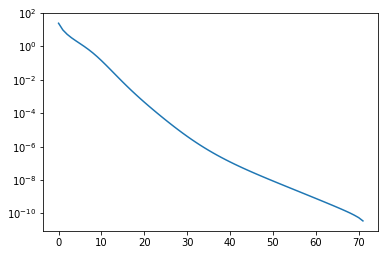

In [133]:
plt.semilogy(res.variables['perceived_irrad'])

### Angular

In [14]:
base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
# base_dir = '/home/oliver/academic/research/kelp-results'

#ns_list = np.logspace(1, 2, 11, base=10).astype(int)[:-1] # Don't do ns=100 - too big
#ns_list = np.logspace(3, 7, base=2).astype(int)
b_list = np.logspace(-3.0, -1, 4)
num_scatters_list = [0, 1, 2, 3]

ns = 32
na_list = [8, 10, 12, 14, 16, 18, 20]
a_water = 0.5
kelp_dist = 'none'
do_fd = True

study_name = 'verify_nokelp_asym_b_scat_ss_sm_th_a05_{}x{}'.format(ns, max(na_list))#max(ns_list), na)
study_dir = os.path.join(base_dir, study_name)

# TODO: Don't actually delete results
#shutil.rmtree(os.path.join(base_dir, study_name), ignore_errors=True)

combine_thread, gs_fut = kelp_compute.verify_kelp_asym_b_scat_ss_angular_compute_scalar_metrics(
    study_name,
    ns, b_list, num_scatters_list,
    na_list, a_water, kelp_dist, do_fd, 
    #fr=2.0, 
    #absorptance_kelp=0.007,
    length_std=0.0,
    blur_radius=0.0,
    lis_opts=None, num_threads=None, 
    base_dir=base_dir,
    dry_run=False
)

Creating new study directory.
Reading existing runs.
Finished reading existing runs.
Running 140 new / 140 total requested tasks.


# IOP Study

In [14]:
base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
# base_dir = '/home/oliver/academic/research/kelp-results'

#ns_list = np.logspace(1, 2, 11, base=10).astype(int)[:-1] # Don't do ns=100 - too big
#ns_list = np.logspace(3, 7, base=2).astype(int)
ns_list = [8,16,32,48,64,72][::-1]
na_list = [4,6,8,10][::-1]
#b_list = np.logspace(-3.0, -1, 4)
#b_list = np.logspace(np.log10(1e-1), np.log10(5e-1), 10)
#b_list = np.logspace(np.log10(5e-1), np.log10(2.5), 10)[1:]
a_water_list = np.linspace(0.1, 0.5, 10)
b_list = np.logspace(np.log10(1e-2), np.log10(1.5), 10)
num_scatters_list = [0, 1, 2, 3]

kelp_dist = 'top-heavy'
do_fd = True

#num_threads = 32
num_threads = None

study_name = 'iop_study_{}x{}'.format(max(ns_list), max(na_list))
study_dir = os.path.join(base_dir, study_name)

combine_thread, gs_fut = kelp_compute.iop_study_compute_scalar_metrics(
    study_name,
    ns_list, na_list, a_water_list, b_list, num_scatters_list,
    kelp_dist, do_fd, 
    fr=5.0, 
    absorptance_kelp=0.7,
    length_std=1.0,
    blur_radius=0.1,
    I0=50.0,
    decay=1.0,
    vsf_type='linear', 
    lis_opts=None, num_threads=num_threads, 
    base_dir=base_dir,
    dry_run=False
)

Appending existing study directory.
[[<function kelp_calculate_scalar_metrics at 0x7ff6a4b81620>, <function kelp_calculate_scalar_metrics at 0x7ff6a4b81620>, <function kelp_calculate_scalar_metrics at 0x7ff6a4b81620>, <function kelp_calculate_scalar_metrics at 0x7ff6a4b81620>, <function kelp_calculate_scalar_metrics at 0x7ff6a4b81620>, <function kelp_calculate_scalar_metrics at 0x7ff6a4b81620>, <function kelp_calculate_scalar_metrics at 0x7ff6a4b81620>, <function kelp_calculate_scalar_metrics at 0x7ff6a4b81620>, <function kelp_calculate_scalar_metrics at 0x7ff6a4b81620>, <function kelp_calculate_scalar_metrics at 0x7ff6a4b81620>, <function kelp_calculate_scalar_metrics at 0x7ff6a4b81620>, <function kelp_calculate_scalar_metrics at 0x7ff6a4b81620>, <function kelp_calculate_scalar_metrics at 0x7ff6a4b81620>, <function kelp_calculate_scalar_metrics at 0x7ff6a4b81620>, <function kelp_calculate_scalar_metrics at 0x7ff6a4b81620>, <function kelp_calculate_scalar_metrics at 0x7ff6a4b81620>, <f

# Rad compare - best num_scatters for each IOP

In [29]:
#study_name = 'verify_kelp_bad_abspt_asym_b_scat_ss_sm_th_a05_100x8'
#study_name = 'verify_kelp_better_abspt_std3_periodic_abs_asym_b_scat_ss_sm_th_a05_79x8'
#study_name = 'verify_nokelp_flat_asym_b_scat_ss_sm_th_a05_32x18'
#study_name = 'verify_real_kelp_asym_b_scat_ss_sm_th_a05_br01_72x10'
study_name = 'iop_study_72x10'
base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
study_dir = os.path.join(base_dir, study_name)

In [30]:
print(study_name)
db_path = os.path.join(study_dir, '{}.db'.format(study_name))
conn = sqlite3.Connection(db_path)

iop_study_72x10


In [90]:
### norm = lambda x: np.linalg.norm(np.ravel(x), ord=2)
#norm = lambda x: np.sqrt(np.sum(x)**2/np.size(x))
#norm = lambda x: np.mean(np.abs(x))
norm = lambda x: np.mean(np.abs(x))

ns_list, na_list, a_water_list, b_list, num_scatters_list = kelp_analyze.get_unique_vals(conn, study_name, ['ns', 'na', 'a_water', 'b', 'num_scatters'])
num_scatters_list = [n for n in num_scatters_list if n >= 0]
ns_arr = np.array(ns_list)
na_arr = np.array(na_list)

tot_err_arr = np.zeros([
    len(a_water_list),
    len(b_list),
    len(num_scatters_list),
])

for i, a_water in enumerate(a_water_list):
    print("{}: a_water={:.2e}".format(i, a_water))
    for j, b in enumerate(b_list):
        print()
        print("{}: b={:.2e}".format(j, b))
        try:
            fd_results_list = kelp_analyze.query_results(
                conn, study_name, base_dir,
                fd_flag=True,
                ns=np.max(ns_arr),
                na=np.max(na_arr),
                a_water=a_water,
                b=b
            )
            fd_rad = fd_results_list[0]['rad'][:].data

            for k, num_scatters in enumerate(num_scatters_list):
                print("n={}".format(num_scatters))
                asym_results_list = kelp_analyze.query_results(
                    conn, study_name, base_dir,
                    ns=np.max(ns_arr),
                    na=np.max(na_arr),
                        fd_flag=False,
                        a_water=a_water,
                        num_scatters=num_scatters,
                        b=b
                )
                asym_rad = asym_results_list[0]['rad'][:].data

                # Calculate error
                tot_err = norm(asym_rad - fd_rad)
                tot_err_arr[i,j,k] = tot_err
        except IndexError:
            print("MISSING.")

0: a_water=1.00e-01

0: b=1.00e-02
n=0
n=1
n=2
n=3

1: b=1.74e-02
n=0
n=1
n=2
n=3

2: b=3.04e-02
n=0
n=1
n=2
n=3

3: b=5.31e-02
n=0
n=1
n=2
n=3

4: b=9.27e-02
n=0
n=1
n=2
n=3

5: b=1.62e-01
n=0
n=1
n=2
n=3

6: b=2.82e-01
n=0
n=1
n=2
n=3

7: b=4.93e-01
n=0
n=1
n=2
n=3

8: b=8.60e-01
n=0
n=1
n=2
n=3

9: b=1.50e+00
n=0
n=1
n=2
n=3
1: a_water=1.44e-01

0: b=1.00e-02
n=0
n=1
n=2
n=3

1: b=1.74e-02
n=0
n=1
n=2
n=3

2: b=3.04e-02
n=0
n=1
n=2
n=3

3: b=5.31e-02
n=0
n=1
n=2
n=3

4: b=9.27e-02
n=0
n=1
n=2
n=3

5: b=1.62e-01
n=0
n=1
n=2
n=3

6: b=2.82e-01
n=0
n=1
n=2
n=3

7: b=4.93e-01
n=0
n=1
n=2
n=3

8: b=8.60e-01
n=0
n=1
n=2
n=3

9: b=1.50e+00
n=0
n=1
n=2
n=3
2: a_water=1.89e-01

0: b=1.00e-02
n=0
n=1
n=2
n=3

1: b=1.74e-02
n=0
n=1
n=2
n=3

2: b=3.04e-02
n=0
n=1
n=2
n=3

3: b=5.31e-02
n=0
n=1
n=2
n=3

4: b=9.27e-02
n=0
n=1
n=2
n=3

5: b=1.62e-01
n=0
n=1
n=2
n=3

6: b=2.82e-01
n=0
n=1
n=2
n=3

7: b=4.93e-01
n=0
n=1
n=2
n=3

8: b=8.60e-01
n=0
n=1
n=2
n=3

9: b=1.50e+00
n=0
n=1
n=2
n=3
3: a_water

In [221]:
err_df = pd.DataFrame([
    dict(
        a_water=a_water_list[i],
        b=b_list[j],
        num_scatters=num_scatters_list[k],
        err=tot_err_arr[i,j,k]
    )
    for i, j, k in np.indices(tot_err_arr.shape).reshape(3,-1).T
])

In [226]:
err_df.to_csv('iop_study_72x10_l1_err.csv',index=False)

# Load pre-computed errors

In [13]:
a_water_list = np.linspace(0.1, 0.5, 10)
b_list = np.logspace(np.log10(1e-2), np.log10(1.5), 10)
num_scatters_list = [0, 1, 2, 3]

err_df = pd.read_csv('iop_study_72x10_l1_err.csv')
tot_err_arr = np.array(err_df['err']).reshape(*map(len,(a_water_list, b_list, num_scatters_list)))

In [14]:
a_water_grid, b_grid = np.meshgrid(a_water_list, b_list, indexing='ij')

## Plot for one a_water

a_water = 0.10


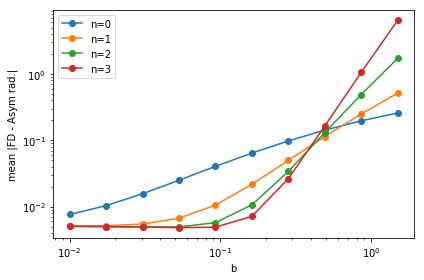

In [100]:
# Pick a_water
i = 0
print("a_water = {:.2f}".format(a_water_list[i]))
#reg_lims = [
#    [1e-2, 3e-1],
#    [1e-1, 6e-0],
#    [4e-1, 6e-0],
#    [4e-1, 6e-0]
#]
b_arr = np.array(b_list)
for k, num_scatters in enumerate(num_scatters_list):
    #inds = np.logical_and(
    #    b_arr > reg_lims[i][0],
    #    b_arr < reg_lims[i][1]
    #)
    #m_err, b_err = robust_exp_regression(b_arr[inds], tot_err_arr[inds, i, k])
    plt.plot(np.array(b_list), tot_err_arr[i,:,k], 'C{}o-'.format(k), label='n={}'.format(num_scatters))#, m={:.2f}'.format(num_scatters, m_err))
    #plt.plot(np.array(b_list), np.exp(b_err)*np.array(b_list)**m_err, 'C{}--'.format(i), alpha=alpha)
    #plt.scatter(b_list, tot_err_arr[:,i, k], c='C{}'.format(i), s=1000*(1-asym_r2_arr[:,i]), alpha=alpha)
plt.legend()
plt.xlabel('b')
plt.ylabel('mean |FD - Asym rad.|')
plt.yscale('log')
plt.xscale('log')
#plt.xlim(1e-4,1e-0)
#plt.ylim(1e-5,2e0)
plt.tight_layout()

# Plot for one num_scatters

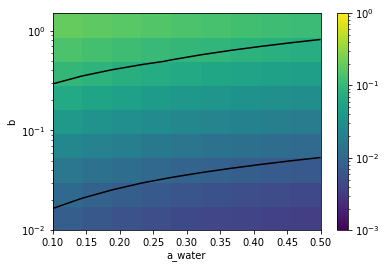

In [42]:
z = tot_err_arr[:,:,0]
#zmin = z.min() #10**np.floor(np.log10(z.min()))*9
#zmax = z.max() #10**np.ceil(np.log10(z.max()))*1.1
zmin = 1e-3
zmax = 1e-0
levels = 1e-2, 1e-1
color_norm = mpl.colors.LogNorm(vmin=zmin, vmax=zmax)
plt.pcolor(a_water_grid, b_grid, z, norm=color_norm)
plt.yscale('log')
plt.xlabel('a_water')
plt.ylabel('b')
plt.colorbar()#, ticks=levels)
plt.contour(a_water_grid, b_grid, z, levels=levels, colors='k')

# Best num_scatters vs. IOPs

In [34]:
best_num_scatters = np.argmin(tot_err_arr, axis=2)
min_err_arr = np.min(tot_err_arr, axis=2)

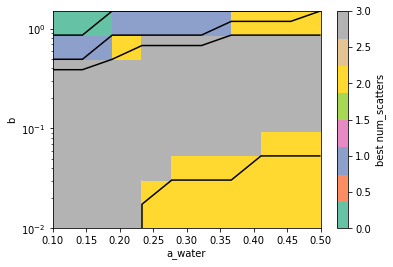

In [52]:
plt.pcolor(a_water_grid, b_grid, best_num_scatters, cmap=mpl.cm.Set2)
plt.yscale('log')
plt.xlabel('a_water')
plt.ylabel('b')
plt.colorbar(label='best num_scatters')
plt.contour(a_water_grid, b_grid, best_num_scatters, colors='k', levels=(0,1,2,3))

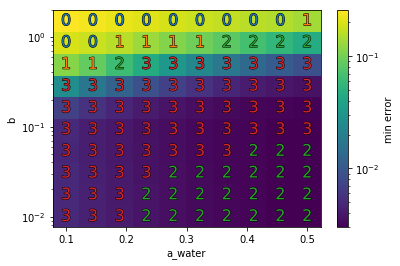

In [70]:
# verts for pcolor
da = a_water_list[1]-a_water_list[0]
dlnb = np.log(b_list[1]) - np.log(b_list[0])
a_verts = np.concatenate([a_water_list, [a_water_list[-1]+da]]) - da/2
b_verts = np.exp(np.concatenate([np.log(b_list), [np.log(b_list)[-1]+dlnb]]) - dlnb/2)
# vert grids
avg, bvg = np.meshgrid(a_verts, b_verts, indexing='ij')

plt.figure(figsize=(6,4))
color_norm = mpl.colors.LogNorm(vmin=np.min(min_err_arr), vmax=np.max(min_err_arr))
plt.pcolor(avg, bvg, min_err_arrb, norm=color_norm)
plt.yscale('log')
plt.xlabel('a_water')
plt.ylabel('b')
plt.colorbar(label='min error')
#plt.contour(a_water_grid, b_grid, best_num_scatters, levels=(0,1,2,3), cmap='plasma')
#plt.contour(a_water_grid, b_grid, min_err_arr, cmap='plasma', norm=color_norm)

for i, a_water in enumerate(a_water_list):
    for j, b in enumerate(b_list):
        x = a_water_list[i]
        y = b_list[j]
        n = best_num_scatters[i,j]
        
        s = str(n)
        fc = mpl.cm.tab10(n)
        fs = 16
        ec = 'k'
        lw=1
        t1 = plt.text(x, y, s, color=fc, fontsize=fs, ha='center', va='center')
        t1.set_path_effects([
            path_effects.withStroke(
                #edgecolor=ec,
                linewidth=lw,
                foreground=ec
            )
        ])
        #t2 = plt.text(x, y, s, fontsize=16, ha='center', va='center')


# Plot err vs. $\xi$

In [78]:
xi.shape

(100,)

In [77]:
er.shape

(100,)

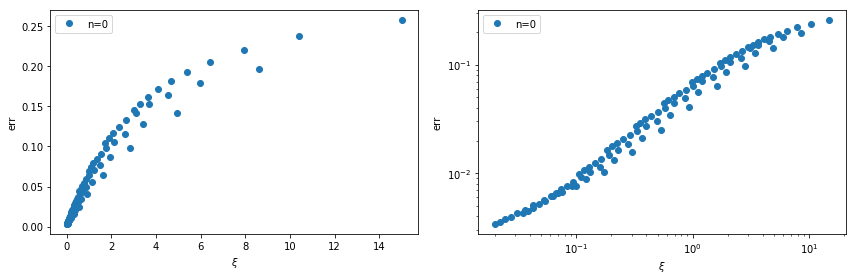

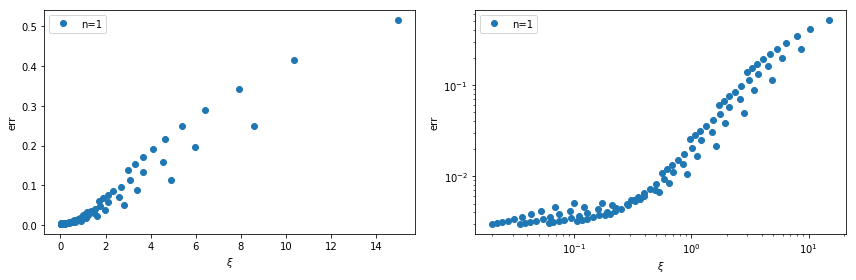

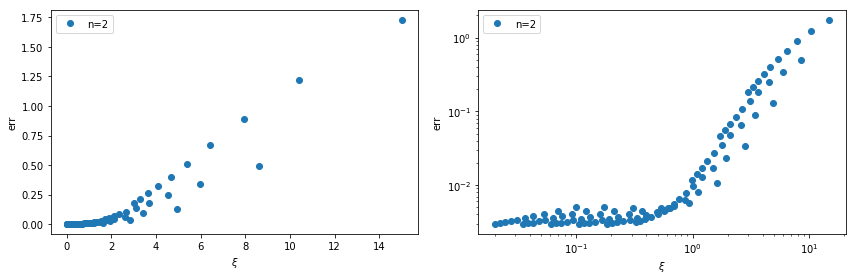

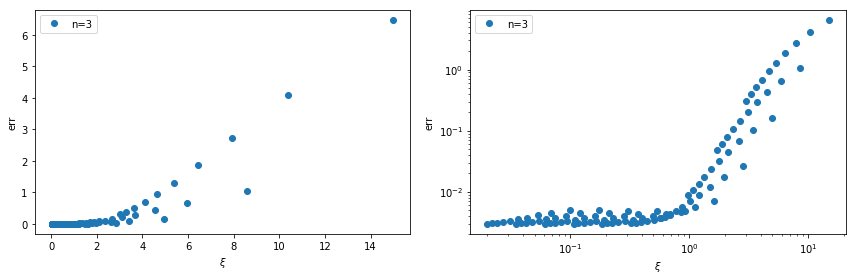

In [109]:
for k in num_scatters_list:
    ar = np.ravel(a_water_grid)
    br = np.ravel(b_grid)
    xi = br/(ar)
    er = np.ravel(tot_err_arr[:,:,k])

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
    ax1.plot(xi, er, 'o', label='n={}'.format(k))
    ax1.set_xlabel(r'$\xi$')
    ax1.set_ylabel('err')
    ax1.legend()

    ax2.plot(xi, er, 'o', label='n={}'.format(k))
    ax2.set_xlabel(r'$\xi$')
    ax2.set_ylabel('err')
    plt.xscale('log')
    plt.yscale('log')
    ax2.legend()
    
    plt.tight_layout()

Only look at $\xi < 1$

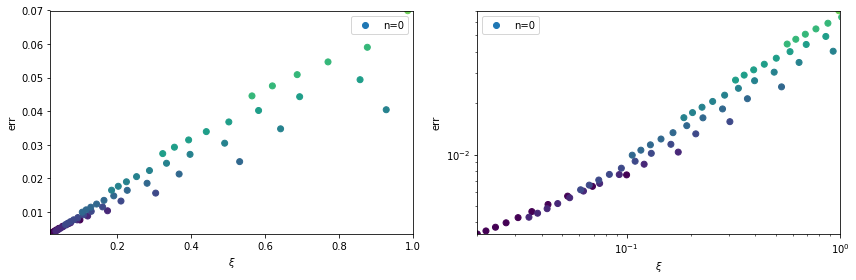

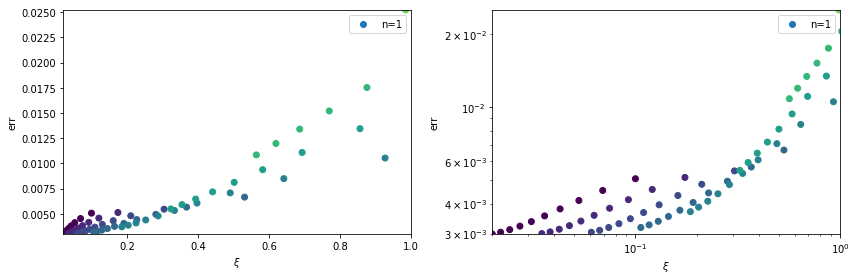

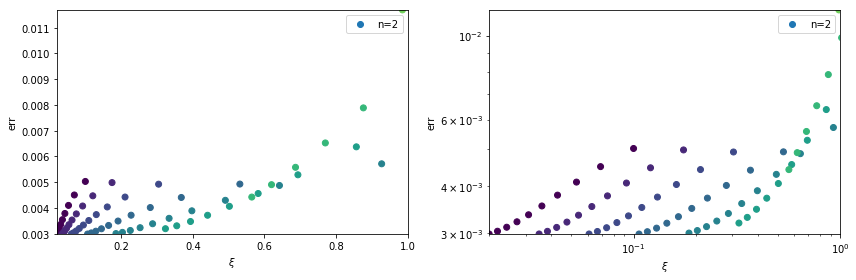

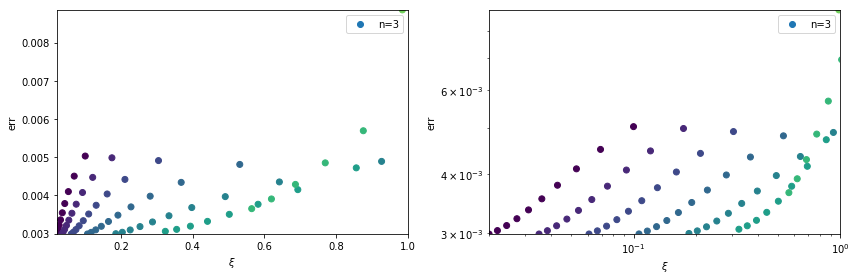

In [142]:
for k in num_scatters_list:
    ar = np.ravel(a_water_grid)
    br = np.ravel(b_grid)
    xi = br/(ar)
    er = np.ravel(tot_err_arr[:,:,k])

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
    ax1.scatter(xi, er, c=np.log(br), label='n={}'.format(k))
    ax1.set_xlim(np.min(xi), 1)
    ax1.set_ylim(np.min(er), np.max(er[xi<1]))
    ax1.set_xlabel(r'$\xi$')
    ax1.set_ylabel('err')
    ax1.legend()

    ax2.scatter(xi, er, c=np.log(br), label='n={}'.format(k))
    ax2.set_xlim(np.min(xi), 1)
    ax2.set_ylim(np.min(er), np.max(er[xi<1]))
    ax2.set_xlabel(r'$\xi$')
    ax2.set_ylabel('err')
    plt.xscale('log')
    plt.yscale('log')
    ax2.legend()
    
    plt.tight_layout()

$\xi=a/(a+b)$

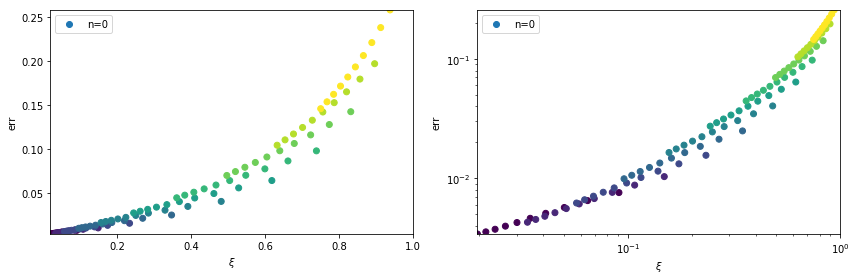

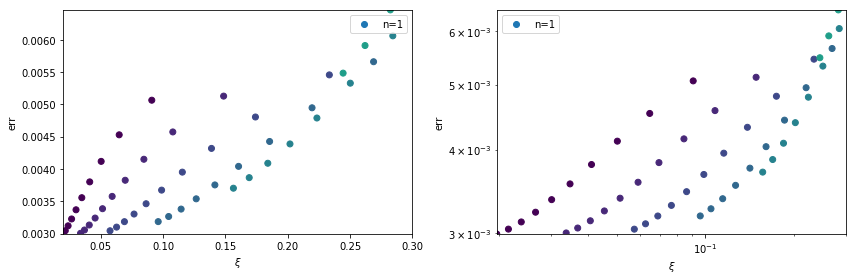

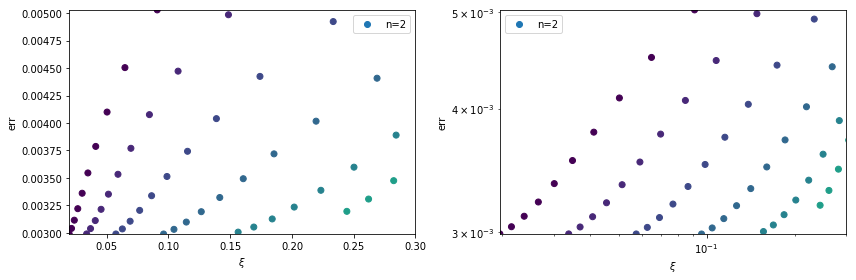

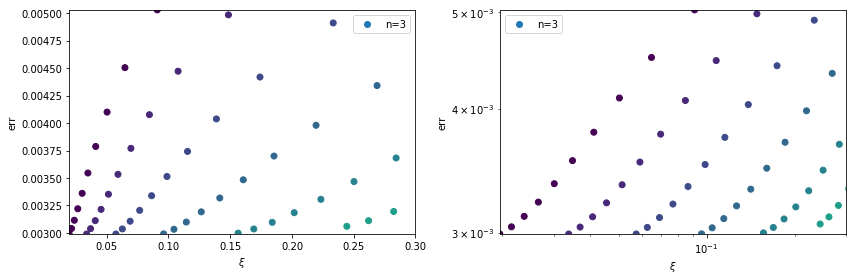

In [138]:
maxvals = [1, 3e-1, 3e-1, 3e-1]
for k in num_scatters_list:
    ar = np.ravel(a_water_grid)
    br = np.ravel(b_grid)
    xi = br/(ar+br)
    er = np.ravel(tot_err_arr[:,:,k])

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
    
    ax1.scatter(xi, er, c=np.log(br), label='n={}'.format(k))
    ax1.set_xlim(np.min(xi), maxvals[k])
    ax1.set_ylim(np.min(er), np.max(er[xi<maxvals[k]]))
    ax1.set_xlabel(r'$\xi$')
    ax1.set_ylabel('err')
    ax1.legend()

    ax2.scatter(xi, er, c=np.log(br),  label='n={}'.format(k))
    ax2.set_xlim(np.min(xi), maxvals[k])
    ax2.set_ylim(np.min(er), np.max(er[xi<maxvals[k]]))
    ax2.set_xlabel(r'$\xi$')
    ax2.set_ylabel('err')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.legend()
    
    plt.tight_layout()

Experiment with $\xi$

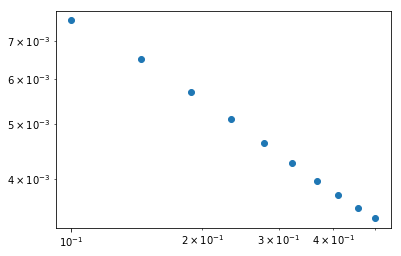

In [176]:
plt.loglog(ar[::10], er[::10], 'o')

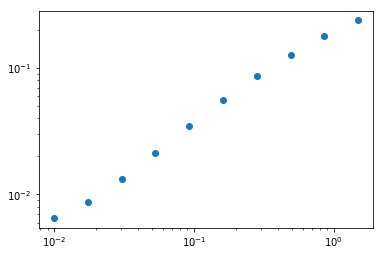

In [174]:
plt.loglog(br[:10], er[10:20], 'o')

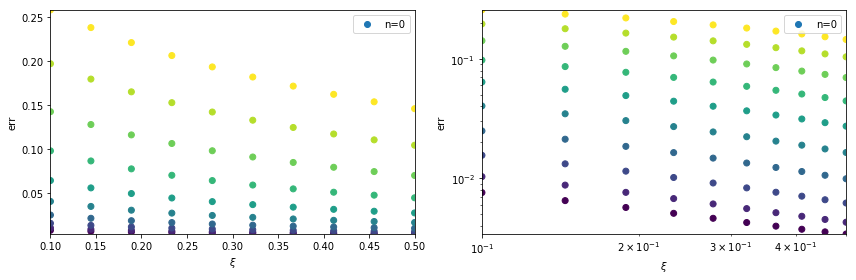

In [168]:
maxvals = [1, 3e-1, 3e-1, 3e-1]
for k in num_scatters_list[:1]:
    ar = np.ravel(a_water_grid)
    br = np.ravel(b_grid)
    xi = ar
    er = np.ravel(tot_err_arr[:,:,k])

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
    
    ax1.scatter(xi, er, c=np.log(br), label='n={}'.format(k))
    ax1.set_xlim(np.min(xi), np.max(xi))
    ax1.set_ylim(np.min(er), np.max(er))
    #ax1.set_xlim(np.min(xi), maxvals[k])
    #ax1.set_ylim(np.min(er), np.max(er[xi<maxvals[k]]))
    ax1.set_xlabel(r'$\xi$')
    ax1.set_ylabel('err')
    ax1.legend()

    ax2.scatter(xi, er, c=np.log(br),  label='n={}'.format(k))
    ax2.set_xlim(np.min(xi), np.max(xi))
    ax2.set_ylim(np.min(er), np.max(er))
    #ax2.set_xlim(np.min(xi), maxvals[k])
    #ax2.set_ylim(np.min(er), np.max(er[xi<maxvals[k]]))
    ax2.set_xlabel(r'$\xi$')
    ax2.set_ylabel('err')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.legend()
    
    plt.tight_layout()

# Fit error

$\varepsilon=\alpha b^{n_1}/a^{n_2}$

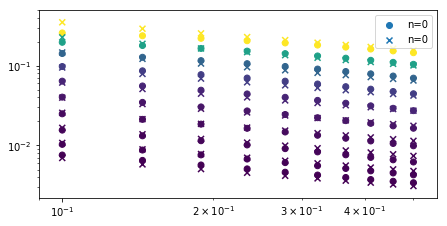

In [292]:
k=0
lr_ok = linear_model.LinearRegression(fit_intercept=True)
X_ok = np.log(np.array(err_df[['a_water', 'b']][err_df['num_scatters']==0]))
y_ok = np.log(np.array(err_df['err'][err_df['num_scatters']==0]))
lr_ok.fit(X_ok, y_ok)

plt.figure(figsize=(12,6))
for k in num_scatters_list[k:k+1]:
    ax = plt.subplot(2,2,k+1)
    ar = np.ravel(a_water_grid)
    br = np.ravel(b_grid)
    xi = ar
    nr = np.ones_like(ar) * k
    er = np.ravel(tot_err_arr[:,:,k])
    
    X = np.log(np.vstack([ar, br]).T)
    er_fit = np.exp(lr_ok.predict(X))
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.scatter(xi, er, c=br, label='n={}'.format(k))
    ax.scatter(xi, er_fit, marker='x', c=br, label='n={}'.format(k))

    ax.legend()
plt.tight_layout()

In [244]:
vals = lr.predict(
    np.array([
        [0,0],
        [1,0],
        [0,1]
    ])
)
alpha = np.exp(vals[0])
n1 = vals[1]-vals[0]
n2 = vals[2]-vals[0]

In [247]:
print(alpha) #coefficient
print(n1) # a exponent
print(n2) # b exponent

0.0800901935575371
-0.5036221020455174
0.7818651567751982


## Try prediction to get better $\xi$

In [273]:
X_fit.shape

(74, 2)

In [274]:
X_predict.shape

(32, 2)

In [277]:
er_fit.shape

(32,)

In [278]:
y.shape

(1, 74)

In [283]:
n2

array([0.05069032])

In [286]:
lr.

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [300]:
y.shape

(100, 1)

In [301]:
y_ok.shape

(100,)

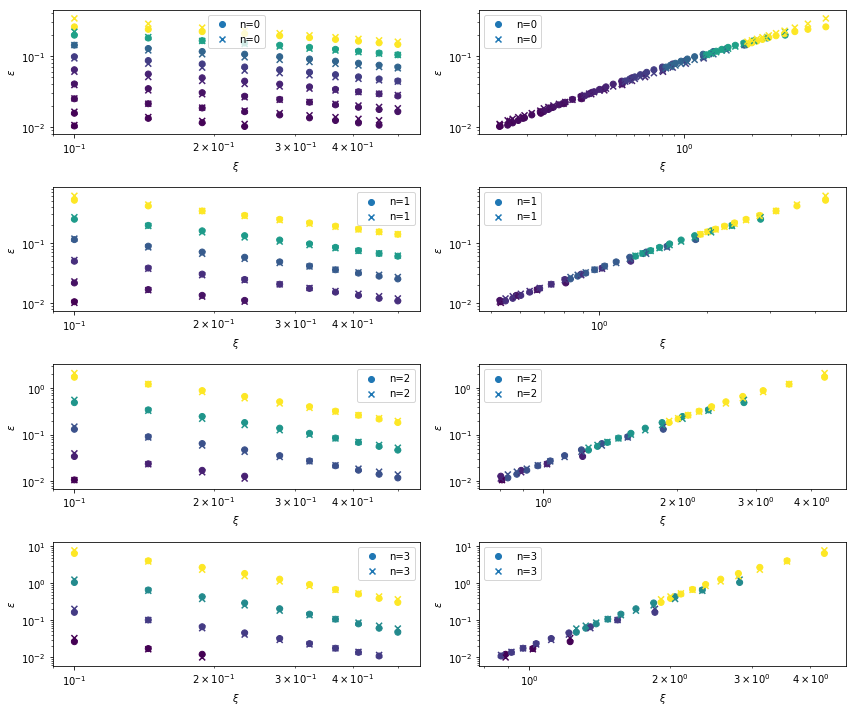

In [363]:
err_floor = 1e-2
plt.figure(figsize=(12,10))
alpha_arr = np.zeros_like(num_scatters_list, dtype=float)
n1_arr = np.zeros_like(num_scatters_list, dtype=float)
n2_arr = np.zeros_like(num_scatters_list, dtype=float)
for k in num_scatters_list:
    # Set up variables, introduce error floor
    er = np.ravel(tot_err_arr[:,:,k])
    inds = er>err_floor
    er = er[inds]
    ar = np.ravel(a_water_grid)[inds]
    br = np.ravel(b_grid)[inds]
    nr = np.ones_like(ar) * k
    
    # Fit & predict
    lr = linear_model.LinearRegression(fit_intercept=True, normalize=True)
    X_fit = np.log(np.array([br, ar]).T)
    y = np.log(er)
    lr.fit(X_fit, y)
    X_predict = np.log(np.vstack([br, ar]).T)
    er_predict = np.exp(lr.predict(X_predict))
    
    # Extract fit coefficients
    if k == -1:
        vals = lr.predict(
            np.array([
                [0,0],
                [1,0],
                [0,1]
            ])
        )
        alpha = float(np.exp(vals[0]))
        n1 = float(vals[1]-vals[0]) # b expnt
        n2 = -float(vals[2]-vals[0]) # a expnt
        alpha_arr[k] = alpha
        n1_arr[k] = n1
        n2_arr[k] = n2
        print('n={}: alpha={:.2e}, n1={:.2e}, n2={:.2e}'.format(k, alpha, n1, n2))
        
    # fitted n=0 vals:
    # alpha=8.40e-02
    # n1=-4.69e-01
    # n2=7.77e-01
        
    alpha = .1
    n1 = .75
    n2 = .5
        
    # Rescale
    xi = br**n1 / ar**n2
    
    # Plot a vs err (left column)
    ax = plt.subplot(len(num_scatters_list),2,2*k+1)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.scatter(ar, er, c=br, label='n={}'.format(k))
    ax.scatter(ar, er_predict, marker='x', c=br, label='n={}'.format(k))
    ax.set_xlabel(r'$\xi$')
    ax.set_ylabel(r'$\varepsilon$')
    ax.legend()
    
    # Plot xi vs err (right column)
    ax = plt.subplot(len(num_scatters_list),2,2*k+2)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.scatter(xi, er, c=br, label='n={}'.format(k))
    ax.scatter(xi, er_predict, marker='x', c=br, label='n={}'.format(k))
    ax.set_xlabel(r'$\xi$')
    ax.set_ylabel(r'$\varepsilon$')
    ax.legend()
plt.tight_layout()

# Plot all together

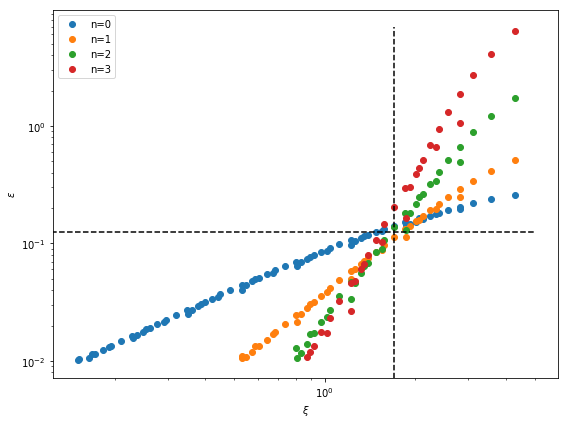

In [400]:
plt.figure(figsize=[8,6])
plt.xscale('log')
plt.yscale('log')
err_floor = 1e-2
for k in num_scatters_list:
    # Set up variables, introduce error floor
    er = np.ravel(tot_err_arr[:,:,k])
    inds = er>err_floor
    er = er[inds]
    ar = np.ravel(a_water_grid)[inds]
    br = np.ravel(b_grid)[inds]
        
    # Rescale
    xi = br**.75 / ar ** .5
    
    # Plot xi vs err (right column)
    plt.scatter(xi, er, label='n={}'.format(k))
    #plt.scatter(xi, er_predict, marker='x', c=br, label='n={}'.format(k))
    
plt.hlines(.125, 0, 5, linestyles='dashed')
plt.vlines(1.7, 0, 7, linestyles='dashed')
plt.xlabel(r'$\xi$')
plt.ylabel(r'$\varepsilon$')
plt.legend()
plt.tight_layout()

# TODO: Fit these lines, use that info to generate rules of thumb.
- Create 2D plots (a vs b) without disc. err.
  - min err
  - best k
  - lowest k to reach error threshold
  - above two are probably identical

# THEN TODO:
- Quantify discretization error via Richardson Extrapolation
- How does disc. error vary with grid size?
- Does it depend on IOPs?

# TODO: Angular Richardson extrapolation?

In [27]:
sm_dashboard(conn, study_name)

In [27]:
print("hi")

hi


In [38]:
p_kelp = kelp_analyze.query_results(conn, study_name,ns=79)[0]['p_kelp'][:].data
ak = -np.log(1-0.07)/4e-4

In [39]:
aw = 0.5

In [40]:
abs_grid = p_kelp*(ak-aw) + aw

In [46]:
np.stack(np.gradient(abs_grid, 10/79)).max()

4.140177513052545

* Dot size should be asym. rel. err. from R.E. (or maybe sum of asym. and FD rel. errs.)

# Analyze Compute Times

In [11]:
import seaborn as sns

ModuleNotFoundError: No module named 'seaborn'

In [216]:
df = kelp_analyze.table_to_df(conn, study_name)

In [ ]:
print("hi")

In [ ]:
fd_df = df[df['fd_flag']==True]

m, b = robust_exp_regression(fd_df['ns'].values, fd_df['compute_time'].values)
plt.plot(fd_df['ns'], fd_df['compute_time'], 'o', label='data')
xx = np.array([np.min(fd_df['ns']), np.max(fd_df['ns'])])
plt.plot(xx, np.exp(b)*xx**m, '--', label='fit (b={:.2f}, m={:.2f})'.format(b, m))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('ns')
plt.ylabel('compute time (seconds)')
plt.title('FD compute times')
plt.legend()

In [ ]:
asym_df = df[df['fd_flag']==False]

m, b = robust_exp_regression(asym_df['ns'].values, asym_df['compute_time'].values)
num_scatters_list = np.unique()
plt.plot(asym_df['ns'], asym_df['compute_time'], 'o', label='data')
xx = np.array([np.min(asym_df['ns']), np.max(asym_df['ns'])])
plt.plot(xx, np.exp(b)*xx**m, '--', label='fit (b={:.2f}, m={:.2f})'.format(b, m))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('ns')
plt.ylabel('compute time (seconds)')
plt.title('FD compute times')
plt.legend()

In [ ]:
sns.pairplot(fd_df)

KeyboardInterrupt: 

/opt/conda/lib/python3.6/site-packages/matplotlib/axis.py:1081: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
/opt/conda/lib/python3.6/site-packages/matplotlib/axis.py:1081: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


In [217]:
sns.distplot(fd_df['ns'])

,id,data_path,absorptance_kelp,a_water,b,ns,na,nx,ny,nz,...,date,git_commit,compute_time,lis_iter,lis_time,lis_resid,flux,pi_1,pi_3,pi_8
0,1,/scratch/kelp-results/verify_kelp_better_abspt...,0.07,0.5,0.316228,10,8,10,10,10,...,Sun Oct 14 06:15:51 2018,df0e52805197bbf615af888bfc47341e495aee9b,0.047547,0,0.000000,0.000000e+00,17335.339721,10.634856,0.195224,4.940361e-04
1,2,/scratch/kelp-results/verify_kelp_better_abspt...,0.07,0.5,0.316228,10,8,10,10,10,...,Sun Oct 14 06:15:52 2018,df0e52805197bbf615af888bfc47341e495aee9b,0.060995,0,0.000000,0.000000e+00,15985.200616,10.750194,0.074544,5.613080e-09
2,3,/scratch/kelp-results/verify_kelp_better_abspt...,0.07,0.5,0.316228,10,8,10,10,10,...,Sun Oct 14 06:15:52 2018,df0e52805197bbf615af888bfc47341e495aee9b,0.079781,0,0.000000,0.000000e+00,16194.517764,10.692908,0.109469,4.683122e-04
3,4,/scratch/kelp-results/verify_kelp_better_abspt...,0.07,0.5,0.316228,10,8,10,10,10,...,Sun Oct 14 06:15:52 2018,df0e52805197bbf615af888bfc47341e495aee9b,0.089712,0,0.000000,0.000000e+00,16160.624570,10.708523,0.102225,3.972081e-06
4,5,/scratch/kelp-results/verify_kelp_better_abspt...,0.07,0.5,0.359381,10,8,10,10,10,...,Sun Oct 14 06:24:12 2018,5b933b79309f1e6f124ae49f5133ea8a7011dad4,0.253567,56,0.056839,5.908422e-13,22941.765172,13.778997,0.418568,1.222616e-03
5,6,/scratch/kelp-results/verify_kelp_better_abspt...,0.07,0.5,0.359381,10,8,10,10,10,...,Sun Oct 14 06:24:12 2018,5b933b79309f1e6f124ae49f5133ea8a7011dad4,0.043826,0,0.000000,0.000000e+00,17335.339721,10.634856,0.195224,4.940361e-04
6,7,/scratch/kelp-results/verify_kelp_better_abspt...,0.07,0.5,0.316228,10,8,10,10,10,...,Sun Oct 14 06:24:12 2018,5b933b79309f1e6f124ae49f5133ea8a7011dad4,0.158640,57,0.091592,6.454332e-13,23067.634047,13.779344,0.429457,1.378945e-03
7,8,/scratch/kelp-results/verify_kelp_better_abspt...,0.07,0.5,0.359381,10,8,10,10,10,...,Sun Oct 14 06:24:12 2018,5b933b79309f1e6f124ae49f5133ea8a7011dad4,0.066426,0,0.000000,0.000000e+00,15803.532385,10.765934,0.058199,0.000000e+00
8,9,/scratch/kelp-results/verify_kelp_better_abspt...,0.07,0.5,0.359381,10,8,10,10,10,...,Sun Oct 14 06:24:12 2018,5b933b79309f1e6f124ae49f5133ea8a7011dad4,0.093159,0,0.000000,0.000000e+00,16071.896171,10.691946,0.103183,6.161877e-04
9,10,/scratch/kelp-results/verify_kelp_better_abspt...,0.07,0.5,0.359381,10,8,10,10,10,...,Sun Oct 14 06:24:13 2018,5b933b79309f1e6f124ae49f5133ea8a7011dad4,0.098369,0,0.000000,0.000000e+00,16022.330377,10.714866,0.092551,5.014558e-06


# Analyze Kelp Distributions

- TODO: Analyze max. gradient norm as a function of frond parameters as a sort of sensitivity analysis
    - fs
    - fr
    - ft
    - absorptance_kelp
    - length_std
    - water_speed
    - a_water?

- Calculate max discretization error based on gradient norm

In [73]:
ns = 64
nz = 1
a_water = 0.2
absorptance_kelp = 0.7
fs = 0.5
fr = 2.0
ft = 4e-4
num_dens = 120
max_length = 10 #6.0
length_std = 1 #0.2 * max_length
zmax = 10
rope_spacing = 10
kelp_dist = 'none'
num_threads=4
blur_radius=0.2
blur_nk = int(np.ceil(2*ns*blur_radius/rope_spacing))
print("blur_nk = {} -> {:.2f}".format(blur_nk, blur_nk * rope_spacing/ns))
#blur_nk=20
abs_grid = kelp_compute.kelp_abs_grid_f90_calculate(
    absorptance_kelp, a_water, 
    ns, nz, 
    num_dens, kelp_dist, 
    fs, fr, ft, 
    max_length, length_std,
    zmax, rope_spacing,
    num_threads,
    blur_radius,
    blur_nk,
    water_speed=0.3,#1.0,
    water_angles='constant'
)
ds = rope_spacing / ns
dz = zmax / nz
abs_grid = abs_grid[:,:,0]
log = False
log_grad = True
if log:
    abs_grid = np.log(abs_grid)
grad = np.stack(np.gradient(abs_grid, ds, ds, edge_order=2))
grad_norm = np.linalg.norm(grad, axis=0)
print(abs_grid.max())
print(grad.max())
print(grad_norm.max())
if log_grad:
    grad_norm = np.log(grad_norm)
    
plt.figure(figsize=(8,6))
plt.imshow(abs_grid)#, extent=(-rope_spacing/2, rope_spacing/2, -rope_spacing/2, rope_spacing/2))
cbar = plt.colorbar()
cont = plt.contour(abs_grid)
cont_grad = plt.contour(grad_norm, cmap='magma')
cbar.add_lines(cont)
cbar.add_lines(cont_grad)
plt.show()

ipv.figure()
nt = 1
grid = mms.gen_grid(nt*ns, nz, 2, 2, rope_spacing, zmax)
x, y, z, theta, phi = grid
xx = x[:,:,0,0]
yy = y[:,:,0,0]
zz = np.tile(abs_grid, (nt, nt))
ipv.plot_surface(xx, yy, zz)
ipv.show()

blur_nk = 3 -> 0.47


ImportError: libgfortran.so.5: cannot open shared object file: No such file or directory

3.842646768447577
1.6542792836562503
1.6544808264605801


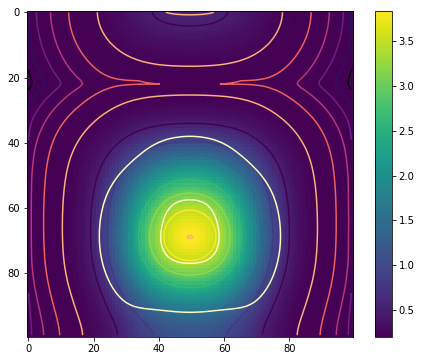

In [16]:
filter_length = 0.5 # (meters)
filter_px = int(np.round(filter_length * ns / rope_spacing)) # num. pixels for filter
ag_filtered = gaussian_filter(abs_grid, filter_px)
grad_filtered = np.stack(np.gradient(ag_filtered, ds, ds, edge_order=2))
grad_filtered_norm = np.linalg.norm(grad_filtered, axis=0)
print(ag_filtered.max())
print(grad_filtered.max())
print(grad_filtered_norm.max())

log_grad = True
if log_grad:
    grad_filtered_norm = np.log(grad_filtered_norm)

plt.figure(figsize=(8,6))
plt.imshow(ag_filtered)#, extent=(-rope_spacing/2, rope_spacing/2, -rope_spacing/2, rope_spacing/2))
cbar = plt.colorbar()
cont = plt.contour(ag_filtered)
cont_grad = plt.contour(grad_filtered_norm, cmap='magma')
cbar.add_lines(cont)
cbar.add_lines(cont_grad)
plt.show()

In [30]:
ipv.figure()
nt = 1
grid = mms.gen_grid(nt*ns, nz, 2, 2, rope_spacing, zmax)
x, y, z, theta, phi = grid
xx = x[:,:,0,0]
yy = y[:,:,0,0]
zz = np.tile(ag_filtered, (nt, nt))
ipv.plot_surface(xx, yy, zz)
ipv.show()

In [143]:
a_kelp = -np.log(absorptance_kelp)/ft
a_kelp

891.6873598468311

Use Taylor's Theorem to bound discretization error (piecewise constant = leading order) on absorption coefficient as a function of grid size

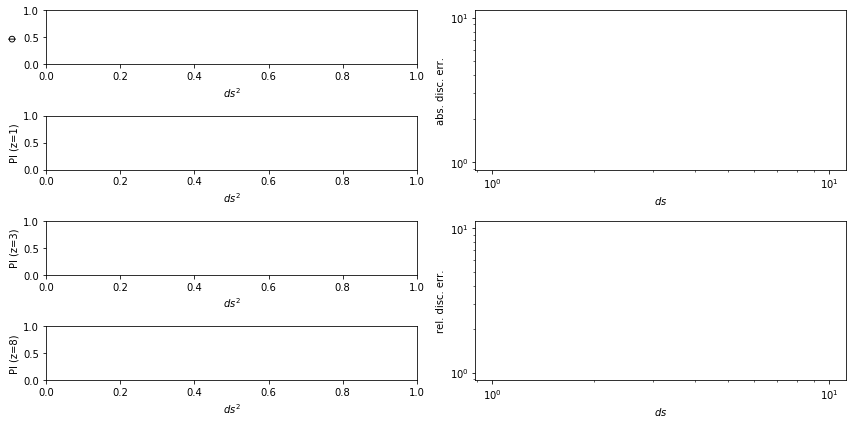

In [18]:
sm_dashboard(conn, study_name, ns_list=ns_list[:-1])